In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pycountry_convert as pc
import matplotlib.ticker as mticker 
import matplotlib.ticker as ticker

In [2]:
#df = pd.read_csv(r"C:\Users\mateo\Dropbox\varios\thesis_yilin\base_final.csv")
df = pd.read_csv('base_final.csv')

In [3]:
df = df[~df['year'].isin([2001, 2002, 2003, 2011, 2012])]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87866 entries, 443 to 89122
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   name                           87866 non-null  object 
 1   citations                      73469 non-null  float64
 2   first_publication_year         73822 non-null  float64
 3   is_presenter                   87866 non-null  int64  
 4   year                           87866 non-null  int64  
 5   link                           87866 non-null  object 
 6   conf_name                      87866 non-null  object 
 7   conf_name_alt                  87866 non-null  object 
 8   country_origin                 82178 non-null  object 
 9   iso3_origin                    83543 non-null  object 
 10  latitude_origin                82178 non-null  float64
 11  longitude_origin               82178 non-null  float64
 12  country_dest                   86249 non-null  ob

# Dealing with Missing Values

In [5]:
df = df[df['travel_data'].notna() & (df['travel_data'] != '')]

**1. affiliation_clean from affiliation**

In [6]:
missing_affiliation= df['affiliation'].isna().sum()
missing_affiliation_clean = df['affiliation_clean'].isna().sum()
missing_affiliation_gs = df['affiliation_gs'].isna().sum()

print(missing_affiliation,missing_affiliation_clean,missing_affiliation_gs)

736 10916 14054


In [7]:
import spacy

# List available models
spacy.info()

{'spacy_version': '3.7.2',
 'location': '/opt/conda/lib/python3.11/site-packages/spacy',
 'platform': 'Linux-6.4.16-linuxkit-aarch64-with-glibc2.35',
 'python_version': '3.11.5',
 'pipelines': {'en_core_web_sm': '3.7.1'}}

In [8]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 7.0 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [9]:
# Load SpaCy model
nlp = spacy.load('en_core_web_sm')

def apply_ner(affiliation):
    try:
        doc = nlp(affiliation)
        entities = [ent.text for ent in doc.ents if ent.label_ in ['ORG', 'GPE','FAC']]
        return entities[0] if entities else None
    except Exception as e:
        return None

# Reprocess the NaN values in affiliation_clean
nan_indices = df[df['affiliation_clean'].isna()].index
df.loc[nan_indices, 'affiliation_clean'] = df.loc[nan_indices, 'affiliation'].apply(apply_ner)

# Check how many NaNs are left
remaining_nans = df['affiliation_clean'].isna().sum()
print(f'Remaining NaNs after reprocessing: {remaining_nans}')

Remaining NaNs after reprocessing: 5802


**2. first_pulication_year**</p>Here are some data that don't match the facts. In my opinion, assuming that a person who is 100 years old and published his first paper in his 20s, attended one of the academic conferences in 2013, thus the appropriate beginning of this variable will be 1930. Namely the valid values are those greater than 1930. </p>Here we selected them and 71546 remain.

In [10]:
# filterd those of first_publication_year greater than 1920
df = df[df['first_publication_year'] > 1930]
print("The number of those of first_publication_year greater than 1930 is :", len(df))

The number of those of first_publication_year greater than 1930 is : 71549


**3. Deal with the difference values between country_origin and contry_eng_origin**

In [11]:
# Find out the line that country origin is missing but country eng origin is not missing
missing_country_origin_rows = df[df['country_origin'].isnull() & df['country_eng_origin'].notnull()]
selected_columns = missing_country_origin_rows[['country_origin', 'country_eng_origin']]
selected_columns

,country_origin,country_eng_origin
81042,NaN,Unknown
81043,NaN,Unknown
81048,NaN,Unknown
81053,NaN,Unknown
81057,NaN,Unknown
...,...,...
89102,NaN,Unknown
89107,NaN,Unknown
89108,NaN,Unknown
89114,NaN,Unknown


In [12]:
df['country_eng_origin'].replace('Unknown', np.nan, inplace=True)
print(df[['country_origin', 'country_eng_origin']])

                    country_origin          country_eng_origin
443    België / Belgique / Belgien  België / Belgium / Belgian
444                  United States               United States
445                  United States               United States
447                         France                      France
448                        Nigeria                     Nigeria
...                            ...                         ...
89113                          NaN                         NaN
89114                          NaN                         NaN
89118                          NaN                         NaN
89119                          NaN                         NaN
89121                          NaN                         NaN

[71549 rows x 2 columns]


In [13]:
df[['country_origin', 'country_eng_origin', 'city_origin', 'city_eng_origin']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 71549 entries, 443 to 89121
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   country_origin      66943 non-null  object
 1   country_eng_origin  66986 non-null  object
 2   city_origin         66986 non-null  object
 3   city_eng_origin     66986 non-null  object
dtypes: object(4)
memory usage: 2.7+ MB


**4. Deal with the missing values between country_dest and city_eng_dest**

In [14]:
missing_country = df['country_eng_dest'].isnull()
missing_city = df['city_eng_dest'].isnull()

print("Missing 'country_eng_dest':", missing_country.sum())
print("Missing 'city_eng_dest':", missing_city.sum())

print(df[missing_country | missing_city][['country_eng_dest', 'city_eng_dest']])

Missing 'country_eng_dest': 0
Missing 'city_eng_dest': 1290
      country_eng_dest city_eng_dest
87374          Unknown           NaN
87375          Unknown           NaN
87376          Unknown           NaN
87377          Unknown           NaN
87378          Unknown           NaN
...                ...           ...
89113          Unknown           NaN
89114          Unknown           NaN
89118          Unknown           NaN
89119          Unknown           NaN
89121          Unknown           NaN

[1290 rows x 2 columns]


In [15]:
df = df.dropna(subset=['country_eng_dest', 'city_eng_dest'])

print("Entries with valid 'country_eng_dest' and 'city_eng_dest':", len(df))
print(df[['country_eng_dest', 'city_eng_dest']])

Entries with valid 'country_eng_dest' and 'city_eng_dest': 70259
      country_eng_dest     city_eng_dest
443      United States       Mississippi
444      United States       Mississippi
445      United States       Mississippi
447      United States       Mississippi
448      United States       Mississippi
...                ...               ...
86904            Spain           Bizkaia
86905            Spain           Bizkaia
86907           Canada  Golden Horseshoe
86909           Canada  Golden Horseshoe
86910    United States  Middlesex County

[70259 rows x 2 columns]


In [16]:
df[['city_eng_dest', 'country_eng_dest', 'city_eng_origin', 'country_eng_origin']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 70259 entries, 443 to 86910
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   city_eng_dest       70259 non-null  object
 1   country_eng_dest    70259 non-null  object
 2   city_eng_origin     65773 non-null  object
 3   country_eng_origin  65773 non-null  object
dtypes: object(4)
memory usage: 2.7+ MB


**The number of city_eng_dest and country_eng_dest is unifed to 70259.**</p>**The number of city_eng_origin and country_eng_origin is unifed to 65773.**

# Summary Statistics

**Here, online conferences are not taken into account as the main focus is on calculating emissions.**

In [17]:
total_conferences = df['conf_name_alt'].unique()
total_count_conferences = len(total_conferences)
total_count_conferences

371

Totally, there are 371 academic conferences hold from 2011 to 2023.

In [18]:
dropped_conf = df[df['conf_name_alt'].str.contains(r'\bOnline\b', case=False, na=False)]
dropped_conf = dropped_conf['conf_name_alt'].unique()
dropped_conf

array(['10th European Meeting of the Urban Economics Association (Online)',
       'The 16th International Symposium on Econometric Theory and Applications: SETA2022 (Online Conference)'],
      dtype=object)

In [19]:
df = df[~df['conf_name_alt'].str.contains(r'\bOnline\b', case=False, na=False)]
no_online_conf = df['conf_name_alt'].unique()
counts_no_online_conf = len(no_online_conf)

print("Number of unique non-online conferences:", counts_no_online_conf)
print("Updated df shape:", df.shape)

Number of unique non-online conferences: 369
Updated df shape: (69723, 61)


In [20]:
names_count = df['name'].count()
unique_names_count = df['name'].nunique()
print(f"Number of participants in 2013-2023: {names_count}")
print(f"Number of unique values in 'name': {unique_names_count}")

presenter_count = df['is_presenter'].sum()

total_participants = df['is_presenter'].count()

presenter_ratio = presenter_count / total_participants

print(f"Number of presenters: {presenter_count}")
print(f"Presenter ratio: {presenter_ratio:.2%}")



Number of participants in 2013-2023: 69723
Number of unique values in 'name': 24747
Number of presenters: 57861
Presenter ratio: 82.99%


In [21]:
unique_counts = df['affiliation_clean'].value_counts()

affiliation = unique_counts.reset_index()
affiliation.columns = ['Affiliation', 'Count']

print(affiliation)

                                            Affiliation  Count
0                            London School of Economics    613
1                                 Federal Reserve Board    597
2                                  University of Oxford    580
3                                 University of Chicago    580
4                                 University of Toronto    513
...                                                 ...    ...
5920                     Delft University of Technology      1
5921      Facultad Latinoamericana de Ciencias Sociales      1
5922  German Institute for Economic Research DIW Ber...      1
5923                                    CentraleSupélec      1
5924                       Northwestern University NBER      1

[5925 rows x 2 columns]


In [22]:
affiliation_counts = df['affiliation_clean'].value_counts()

result_df = affiliation_counts.reset_index()
result_df.columns = ['affiliation_clean', 'Count'] 

top_affiliations = result_df.head(22)

print(top_affiliations)

               affiliation_clean  Count
0     London School of Economics    613
1          Federal Reserve Board    597
2           University of Oxford    580
3          University of Chicago    580
4          University of Toronto    513
5     University of Pennsylvania    488
6                      Hong Kong    455
7                 Bank of Canada    433
8            Columbia University    424
9                Yale University    424
10           New York University    420
11       Northwestern University    380
12            Indiana University    379
13  Toulouse School of Economics    372
14        University of Mannheim    369
15        University of Michigan    364
16       University of Minnesota    363
17           Stanford University    360
18                    Università    358
19         University of Warwick    356
20            Harvard University    349
21          Princeton University    325


In [23]:
transport_types = df['best_opt_transport'].explode()

transport_counts = transport_types.value_counts()
print(transport_counts)

best_opt_transport
Fly           38297
Train         17270
Bus            5825
Line           2657
Subway         2326
Taxi           1415
Drive           459
Shuttle         453
Tram            314
BART            286
Night           180
Car              84
Caltrain         69
Towncar          33
Ferry            26
Helicopter       11
Metro             7
Travel            4
shuttle           2
Name: count, dtype: int64


### 1. The average price paid if everyone takes the best, fastest and cheapest option

**The average price paid if everyone takes the best option:**

In [24]:
def convert_price(price):
    if isinstance(price, str):
        if price.lower() in ['none']:
            return 0
        price = price.replace('£', '').replace(',', '')
        if '–' in price:
            price = price.split('–')[0]
        return float(price)
    return price 

In [25]:
df['best_opt_price'] = df['best_opt_price'].apply(convert_price)

mean_price_best = df['best_opt_price'].mean()
print(f"Mean of best_opt_price: {mean_price_best:.2f}￡")

Mean of best_opt_price: 188.82￡


**The average price paid if everyone takes the fastest option:**

In [26]:
df['fastest_opt_price'] = df['fastest_opt_price'].apply(convert_price)

mean_price_fastest = df['fastest_opt_price'].mean()
print(f"Mean of fastest_opt_price : {mean_price_fastest:.2f}￡")

Mean of fastest_opt_price : 190.76￡


**The average price paid if everyone takes the cheapest option:**

In [27]:
df['cheapest_opt_price'] = df['cheapest_opt_price'].apply(convert_price)

mean_price_cheapest = df['cheapest_opt_price'].mean()
print(f"Mean of cheapest_opt_price : {mean_price_cheapest:.2f}￡")

Mean of cheapest_opt_price : 152.35￡


### 2. Carbon Dioxide Emission

#### 2.1 Carbon dioxide emissions of 3 transportation options separately

In [28]:
def clean_and_convert_time(time_str):
    try:
        match = re.search(r'(?:(\d+)\s*d\s*)?(?:(\d+)\s*h\s*)?(?:(\d+)\s*m\s*)?', time_str)
        days, hours, minutes = 0, 0, 0
        if match:
            days = int(match.group(1)) if match.group(1) else 0
            hours = int(match.group(2)) if match.group(2) else 0
            minutes = int(match.group(3)) if match.group(3) else 0
        return days * 1440 + hours * 60 + minutes
    except Exception as e:
        print(f"Error processing '{time_str}': {e}")
        return None  

print("Valid conversions:", df['best_opt_time'].notna().sum())
print("Conversion failures:", df['best_opt_time'].isna().sum())

print("Sample of failed conversions:")
print(df[df['best_opt_time'].isna()][['best_opt_time']])

Valid conversions: 69723
Conversion failures: 0
Sample of failed conversions:
Empty DataFrame
Columns: [best_opt_time]
Index: []


In [29]:
def time_to_minutes(time_str):
    if isinstance(time_str, str):
        hours = 0
        minutes = 0
        # Extract hours
        hours_match = re.search(r'(\d+)h', time_str)
        if hours_match:
            hours = int(hours_match.group(1))
        # Extract minutes
        minutes_match = re.search(r'(\d+)min', time_str)
        if minutes_match:
            minutes = int(minutes_match.group(1))
        return hours * 60 + minutes
    return None

In [30]:
df['best_opt_time'] = df['best_opt_time'].apply(time_to_minutes)
df['fastest_opt_time'] = df['fastest_opt_time'].apply(time_to_minutes)
df['cheapest_opt_time'] = df['cheapest_opt_time'].apply(time_to_minutes)

In [31]:
emission_data = {
    'fly': 4.167,
    'fly_combined': 4.167 * 0.95,
    'drive': 0.056,
    'taxi': 0.056, 
    'car': 0.056,
    'helicopter': 1.77,
    'train': 0.018,
    'bus': 0.15,
    'shuttle': 0.15,  
    'subway': 0.078,
    'metro': 0.078,
    'line': 0.078,
    'tram': 0.078,
    'ferry': 0.36
}

def calculate_emissions(time_min, transport):
    if pd.isna(time_min) or pd.isna(transport):
        return None
    transport = transport.lower().strip('[]').replace("'", "").split(',')
    transport = [t.strip() for t in transport]

    if len(transport) == 1:
        transport_type = transport[0]
        return time_min * emission_data.get(transport_type, 0) 
    elif 'fly' in transport:
        return time_min * emission_data['fly_combined']
    else:
        return time_min * max(emission_data.get(t, 0) for t in transport)

df['best_opt_emission'] = df.apply(lambda row: calculate_emissions(row['best_opt_time'], row['best_opt_transport']), axis=1)
df['fastest_opt_emission'] = df.apply(lambda row: calculate_emissions(row['fastest_opt_time'], row['fastest_opt_transport']), axis=1)
df['cheapest_opt_emission'] = df.apply(lambda row: calculate_emissions(row['cheapest_opt_time'], row['cheapest_opt_transport']), axis=1)    

#df1 = df.copy()

df[['best_opt_emission', 'fastest_opt_emission','cheapest_opt_emission', 'best_opt_time', 'fastest_opt_time','cheapest_opt_time','best_opt_transport','fastest_opt_transport', 'cheapest_opt_transport']].head()


,best_opt_emission,fastest_opt_emission,cheapest_opt_emission,best_opt_time,fastest_opt_time,cheapest_opt_time,best_opt_transport,fastest_opt_transport,cheapest_opt_transport
443,3962.817,3962.8170,3962.81700,951,951,951,Fly,['Fly'],['Fly']
444,7038.063,6996.3930,7802.49915,1689,1679,1971,Fly,['Fly'],"['Fly', 'bus']"
445,16.380,3602.3715,4136.78925,910,910,1045,Train,"['Train', 'fly']","['Train', 'fly']"
447,8000.640,8000.6400,9009.88740,1920,1920,2276,Fly,['Fly'],"['Fly', 'bus']"
448,7129.737,4219.9209,7538.10300,1711,1066,1809,Fly,"['Taxi', 'fly']",['Fly']


#### 2.2 The Min & Max emissions and option

In [32]:
df['min_emission'] = df[['best_opt_emission', 'fastest_opt_emission', 'cheapest_opt_emission']].min(axis=1)
df['max_emission'] = df[['best_opt_emission', 'fastest_opt_emission', 'cheapest_opt_emission']].max(axis=1)

print(df[['best_opt_emission', 'fastest_opt_emission', 'cheapest_opt_emission', 'min_emission', 'max_emission']].head())

     best_opt_emission  fastest_opt_emission  cheapest_opt_emission  \
443           3962.817             3962.8170             3962.81700   
444           7038.063             6996.3930             7802.49915   
445             16.380             3602.3715             4136.78925   
447           8000.640             8000.6400             9009.88740   
448           7129.737             4219.9209             7538.10300   

     min_emission  max_emission  
443     3962.8170    3962.81700  
444     6996.3930    7802.49915  
445       16.3800    4136.78925  
447     8000.6400    9009.88740  
448     4219.9209    7538.10300  


In [33]:
# kg to tonnes

df['best_opt_emission'] = df['best_opt_emission'] / 1000
df['fastest_opt_emission'] = df['fastest_opt_emission'] / 1000
df['cheapest_opt_emission'] = df['cheapest_opt_emission'] / 1000
df['min_emission'] = df['min_emission'] / 1000
df['max_emission'] = df['max_emission'] / 1000
print(df[['best_opt_emission', 'fastest_opt_emission', 'cheapest_opt_emission', 'min_emission', 'max_emission']].head())

     best_opt_emission  fastest_opt_emission  cheapest_opt_emission  \
443           3.962817              3.962817               3.962817   
444           7.038063              6.996393               7.802499   
445           0.016380              3.602371               4.136789   
447           8.000640              8.000640               9.009887   
448           7.129737              4.219921               7.538103   

     min_emission  max_emission  
443      3.962817      3.962817  
444      6.996393      7.802499  
445      0.016380      4.136789  
447      8.000640      9.009887  
448      4.219921      7.538103  


In [34]:
def determine_emission_options(row):
    large_value = float('inf')
    small_value = float('-inf')

    emissions = {
        'best': row['best_opt_emission'] if row['best_opt_emission'] is not None else large_value,
        'fastest': row['fastest_opt_emission'] if row['fastest_opt_emission'] is not None else large_value,
        'cheapest': row['cheapest_opt_emission'] if row['cheapest_opt_emission'] is not None else large_value
    }

    min_emission = min([value for value in emissions.values() if value != large_value])
    max_emission = max([value for value in emissions.values() if value != small_value])

    min_emission_opt = [k for k, v in emissions.items() if v == min_emission]
    max_emission_opt = [k for k, v in emissions.items() if v == max_emission]

    return ', '.join(min_emission_opt) if min_emission_opt else 'No valid emission data', ', '.join(max_emission_opt) if max_emission_opt else 'No valid emission data'

df[['min_emission_opt', 'max_emission_opt']] = df.apply(lambda row: determine_emission_options(row), axis=1, result_type='expand')

print(df[[ 'best_opt_emission', 'fastest_opt_emission', 'cheapest_opt_emission', 'min_emission_opt', 'max_emission_opt']].head())

     best_opt_emission  fastest_opt_emission  cheapest_opt_emission  \
443           3.962817              3.962817               3.962817   
444           7.038063              6.996393               7.802499   
445           0.016380              3.602371               4.136789   
447           8.000640              8.000640               9.009887   
448           7.129737              4.219921               7.538103   

            min_emission_opt         max_emission_opt  
443  best, fastest, cheapest  best, fastest, cheapest  
444                  fastest                 cheapest  
445                     best                 cheapest  
447            best, fastest                 cheapest  
448                  fastest                 cheapest  


#### 2.3 Total emissions for each conference

In [35]:
df2 = df.copy()

In [36]:

emissions_sum = df2.groupby('conf_name_alt').agg({
    'best_opt_emission': 'sum',
    'fastest_opt_emission': 'sum',
    'cheapest_opt_emission': 'sum',
    'min_emission': 'sum',
    'max_emission': 'sum'
}).reset_index()

emissions_sum.rename(columns={
    'best_opt_emission': 'total_best_emission_tonnes',
    'fastest_opt_emission': 'total_fastest_emission_tonnes',
    'cheapest_opt_emission': 'total_cheapest_emission_tonnes',
    'min_emission': 'total_min_emission_tonnes',
    'max_emission': 'total_max_emission_tonnes'
}, inplace=True)

df2 = pd.merge(df2, emissions_sum, on='conf_name_alt', how='left')

print("Total emissions for each conference (tonnes):")
emissions_sum

Total emissions for each conference (tonnes):


,conf_name_alt,total_best_emission_tonnes,total_fastest_emission_tonnes,total_cheapest_emission_tonnes,total_min_emission_tonnes,total_max_emission_tonnes
0,2015 AFA Annual Meeting,150.870574,200.399027,193.252549,132.776273,220.272653
1,IAAE 2019 Annual Conference,708.144639,960.226879,998.638940,671.809485,1022.613363
2,ITEA Annual Conference on Transportation Econ...,121.117474,194.036496,183.254524,116.083693,205.187668
3,(Virtual) Korean Economic Review International...,114.627053,161.256020,173.069453,107.094063,178.217937
4,106th Annual Conference on Taxation,219.240878,394.720069,361.729762,177.788195,425.065898
...,...,...,...,...,...,...
364,XXXIV Jornadas de Economía Industrial,178.196127,227.729357,234.977416,167.545802,248.016208
365,XXXIX Simposio of the Spanish Economic Associa...,254.049870,351.314262,372.422551,245.232377,379.120795
366,XXXVIII Jornadas de Economía Industrial,48.020039,107.175755,97.792127,43.109440,118.341619
367,XXXVIII Simposio de la Asociación Española de ...,181.884306,321.381875,295.241035,164.853325,350.443497


In [37]:
total_best_emis_mean = df2['total_best_emission_tonnes'].mean()
total_fastest_emis_mean = df2['total_fastest_emission_tonnes'].mean()
total_cheapest_emis_mean = df2['total_cheapest_emission_tonnes'].mean()
total_min_emis_mean = df2['total_min_emission_tonnes'].mean()
total_max_emis_mean = df2['total_max_emission_tonnes'].mean()

print("avarage emissions of 369 conferences in 2013-2023: ")
print(f"mean of total_best_emis: {total_best_emis_mean:.2f}tonnes")
print(f"mean of total_fastest_emiss: {total_fastest_emis_mean:.2f}tonnes")
print(f"mean of total_cheapest_emiss: {total_cheapest_emis_mean:.2f}tonnes")
print(f"mean of total_min_emiss: {total_min_emis_mean:.2f}tonnes")
print(f"mean of total_max_emiss: {total_max_emis_mean:.2f}tonnes")

avarage emissions of 369 conferences in 2013-2023: 
mean of total_best_emis: 617.15tonnes
mean of total_fastest_emiss: 847.53tonnes
mean of total_cheapest_emiss: 840.27tonnes
mean of total_min_emiss: 559.98tonnes
mean of total_max_emiss: 924.10tonnes


In [38]:
total_best_emis_1 = total_best_emis_mean * 369
total_fastest_emis_1 = total_fastest_emis_mean * 369
total_cheapest_emis_1 = total_cheapest_emis_mean * 369
total_min_emis_1 = total_min_emis_mean * 369
total_max_emis_1 = total_max_emis_mean * 369

print("total emissions of 369 conferences in 2013-2023: ")
print(f"total 369 conferences emission of best option: {total_best_emis_1:.2f}tonnes")
print(f"total 369 conferences emission of fastest option: {total_fastest_emis_1:.2f}tonnes")
print(f"total 369 conferences emission of cheapest option: {total_cheapest_emis_1:.2f}tonnes")
print(f"total 369 conferences emission of min option: {total_min_emis_1:.2f}tonnes")
print(f"total 369 conferences emission of max option: {total_max_emis_1:.2f}tonnes")


total emissions of 369 conferences in 2013-2023: 
total 369 conferences emission of best option: 227730.16tonnes
total 369 conferences emission of fastest option: 312737.92tonnes
total 369 conferences emission of cheapest option: 310058.90tonnes
total 369 conferences emission of min option: 206633.85tonnes
total 369 conferences emission of max option: 340993.29tonnes


In [39]:
total_best_emis_1 = total_best_emis_mean * 369
total_fastest_emis_mean = df2['total_fastest_emission_tonnes'].mean()
total_cheapest_emis_mean = df2['total_cheapest_emission_tonnes'].mean()
total_min_emis_mean = df2['total_min_emission_tonnes'].mean()
total_max_emis_mean = df2['total_max_emission_tonnes'].mean()

print("avarage emissions of 369 conferences in 2013-2023: ")
print(f"mean of total_best_emis: {total_best_emis_mean:.2f}tonnes")
print(f"mean of total_fastest_emiss: {total_fastest_emis_mean:.2f}tonnes")
print(f"mean of total_cheapest_emiss: {total_cheapest_emis_mean:.2f}tonnes")
print(f"mean of total_min_emiss: {total_min_emis_mean:.2f}tonnes")
print(f"mean of total_max_emiss: {total_max_emis_mean:.2f}tonnes")

avarage emissions of 369 conferences in 2013-2023: 
mean of total_best_emis: 617.15tonnes
mean of total_fastest_emiss: 847.53tonnes
mean of total_cheapest_emiss: 840.27tonnes
mean of total_min_emiss: 559.98tonnes
mean of total_max_emiss: 924.10tonnes


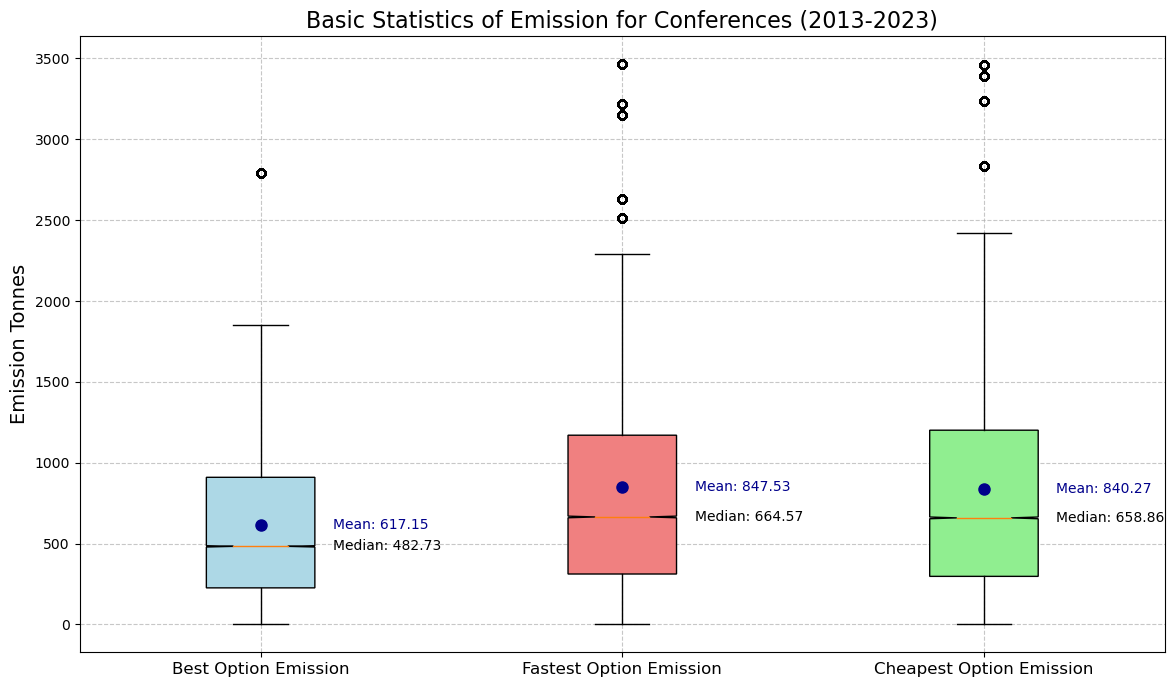

In [40]:
# boxplot

plt.figure(figsize=(14, 8))

data_to_plot = [
    df2['total_best_emission_tonnes'],
    df2['total_fastest_emission_tonnes'],
    df2['total_cheapest_emission_tonnes']
]

box = plt.boxplot(data_to_plot, patch_artist=True, notch=True, vert=True)

colors = ['lightblue', 'lightcoral', 'lightgreen']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

for i, data in enumerate(data_to_plot):
    mean_value = data.mean()
    median_value = data.median()
    
    plt.plot([i + 1], [mean_value], color='darkblue', marker='o', markersize=8)
    plt.text(i + 1.2, mean_value, f'Mean: {mean_value:.2f}', verticalalignment='center', fontsize=10, color='darkblue')
    
    plt.text(i + 1.2, median_value, f'Median: {median_value:.2f}', verticalalignment='center', fontsize=10, color='black')

plt.xticks([1, 2, 3], ['Best Option Emission', 'Fastest Option Emission', 'Cheapest Option Emission'], fontsize=12)

plt.title('Basic Statistics of Emission for Conferences (2013-2023)', fontsize=16)
plt.ylabel('Emission Tonnes', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.subplots_adjust(right=0.9)

plt.show()

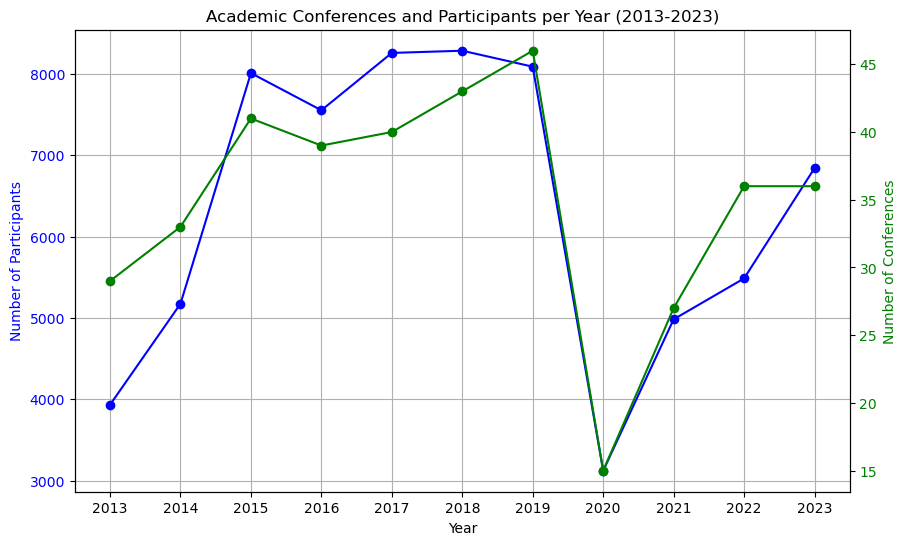

In [41]:

participants_per_year = df2.groupby('year')['conf_name_alt'].count()

# Group by 'year' and get the number of unique conferences each year
conference_counts = df.groupby('year')['conf_name_alt'].nunique()

years = list(range(2013, 2024))
participants_per_year = participants_per_year.reindex(years, fill_value=0)
conference_counts = conference_counts.reindex(years, fill_value=0)

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(participants_per_year.index, participants_per_year.values, marker='o', color='b', label='Participants')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Participants', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticks(years)
ax1.set_xticklabels(years)

ax2 = ax1.twinx()
ax2.plot(conference_counts.index, conference_counts.values, marker='o', color='g', label='Conferences')
ax2.set_ylabel('Number of Conferences', color='g')
ax2.tick_params(axis='y', labelcolor='g')

plt.title('Academic Conferences and Participants per Year (2013-2023)')
ax1.grid(True)

plt.show()

In [42]:
print(df2.columns)


Index(['name', 'citations', 'first_publication_year', 'is_presenter', 'year',
       'link', 'conf_name', 'conf_name_alt', 'country_origin', 'iso3_origin',
       'latitude_origin', 'longitude_origin', 'country_dest', 'iso3_dest',
       'latitude_dest', 'longitude_dest', 'unique_id', 'location_id',
       'affiliation', 'affiliation_clean', 'affiliation_gs', 'city_origin',
       'city_eng_origin', 'country_eng_origin', 'city_dest', 'city_eng_dest',
       'conf_venue', 'conf_venue_alt', 'country_eng_dest', 'travel_data',
       'verified', 'best', 'travel_options', 'first_option_is_best',
       'best_opt_price', 'best_opt_time', 'best_opt_transport',
       'fastest_opt_price', 'fastest_opt_time', 'fastest_opt_transport',
       'slowest_opt_price', 'slowest_opt_time', 'slowest_opt_transport',
       'cheapest_opt_price', 'cheapest_opt_time', 'cheapest_opt_transport',
       'm_expens_opt_price', 'm_expens_opt_time', 'm_expens_opt_transport',
       'cheapest_flying_opt_price', 'che

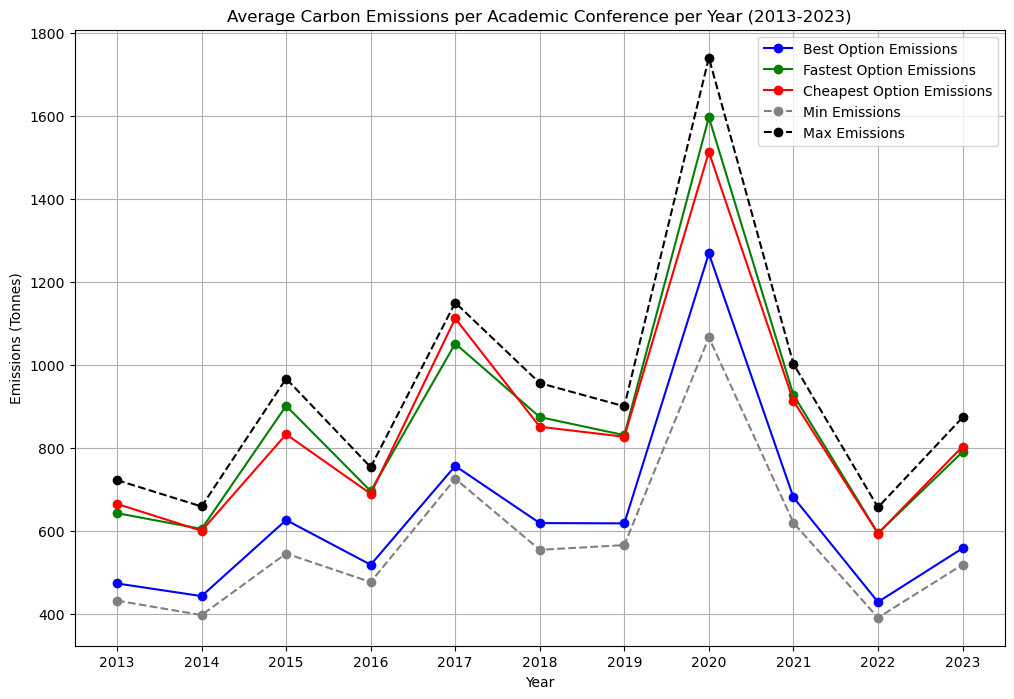

In [43]:
average_emissions_per_year = df2.pivot_table(
    index='year', 
    values=[
        'total_best_emission_tonnes', 
        'total_fastest_emission_tonnes', 
        'total_cheapest_emission_tonnes', 
        'total_min_emission_tonnes', 
        'total_max_emission_tonnes'
    ],
    aggfunc='mean'
)

plt.figure(figsize=(12, 8))
plt.plot(average_emissions_per_year.index, average_emissions_per_year['total_best_emission_tonnes'], label='Best Option Emissions', marker='o', color='blue')
plt.plot(average_emissions_per_year.index, average_emissions_per_year['total_fastest_emission_tonnes'], label='Fastest Option Emissions', marker='o', color='green')
plt.plot(average_emissions_per_year.index, average_emissions_per_year['total_cheapest_emission_tonnes'], label='Cheapest Option Emissions', marker='o', color='red')
plt.plot(average_emissions_per_year.index, average_emissions_per_year['total_min_emission_tonnes'], label='Min Emissions', linestyle='--', marker='o', color='gray')
plt.plot(average_emissions_per_year.index, average_emissions_per_year['total_max_emission_tonnes'], label='Max Emissions', linestyle='--', marker='o', color='black')

plt.title('Average Carbon Emissions per Academic Conference per Year (2013-2023)')
plt.xlabel('Year')
plt.ylabel('Emissions (Tonnes)')

plt.xticks(average_emissions_per_year.index)
plt.legend()
plt.grid(True)
plt.show()


In [44]:

best_emis_col = 'total_best_emission_tonnes'  
fastest_emis_col = 'total_fastest_emission_tonnes'   
cheapest_emis_col = 'total_cheapest_emission_tonnes'  

def calculate_average_emissions(df2):
    average_emissions = {
        'year': [],
        'average_best_emis_tonnes': [],
        'average_fastest_emis_tonnes': [],
        'average_cheapest_emis_tonnes': []
    }
    
    years = df2['year'].unique()
    
    for year in range(2013, 2024):
        yearly_data = df2[df2['year'] == year]
        
        num_participants_best = yearly_data[best_emis_col].count()
        num_participants_fastest = yearly_data[fastest_emis_col].count()
        num_participants_cheapest = yearly_data[cheapest_emis_col].count()
        
        avg_best = yearly_data[best_emis_col].sum() / num_participants_best if num_participants_best > 0 else 0
        avg_fastest = yearly_data[fastest_emis_col].sum() / num_participants_fastest if num_participants_fastest > 0 else 0
        avg_cheapest = yearly_data[cheapest_emis_col].sum() / num_participants_cheapest if num_participants_cheapest > 0 else 0

        average_emissions['year'].append(year)
        average_emissions['average_best_emis_tonnes'].append(avg_best)
        average_emissions['average_fastest_emis_tonnes'].append(avg_fastest)
        average_emissions['average_cheapest_emis_tonnes'].append(avg_cheapest)
    
    return pd.DataFrame(average_emissions)

average_emissions_df2 = calculate_average_emissions(df2)

average_emissions_df2

,year,average_best_emis_tonnes,average_fastest_emis_tonnes,average_cheapest_emis_tonnes
0,2013,474.156247,643.483888,665.860717
1,2014,443.736192,605.505191,600.963248
2,2015,627.028761,902.140484,833.439265
3,2016,519.230518,696.594675,690.173242
4,2017,757.264156,1051.997174,1112.559279
5,2018,619.610012,874.895468,851.663676
6,2019,618.944700,831.527980,827.548206
7,2020,1269.073964,1597.235768,1513.641063
8,2021,681.596783,928.419823,913.973929
9,2022,429.604743,595.205167,594.445917


In [45]:

best_emis_col = 'best_opt_emission'  
fastest_emis_col = 'fastest_opt_emission'  
cheapest_emis_col = 'cheapest_opt_emission'
min_emis_col = 'min_emission'
max_emis_col = 'max_emission'

def calculate_average_emissions_per_participant(df2):
    average_emissions = {
        'year': [],
        'average_best_emis_per_participant': [],
        'average_fastest_emis_per_participant': [],
        'average_cheapest_emis_per_participant': [],
        'average_min_emis_per_participant': [],
        'average_max_emis_per_participant': []
    }
    
    years = df2['year'].unique()
    
    for year in range(2013, 2024):
        yearly_data = df2[df2['year'] == year]
        
        num_participants_best = yearly_data[best_emis_col].count()
        num_participants_fastest = yearly_data[fastest_emis_col].count()
        num_participants_cheapest = yearly_data[cheapest_emis_col].count()
        num_participants_min = yearly_data[min_emis_col].count()
        num_participants_max = yearly_data[max_emis_col].count()
        
        avg_best_per_participant = yearly_data[best_emis_col].sum() / num_participants_best if num_participants_best > 0 else 0
        avg_fastest_per_participant = yearly_data[fastest_emis_col].sum() / num_participants_fastest if num_participants_fastest > 0 else 0
        avg_cheapest_per_participant = yearly_data[cheapest_emis_col].sum() / num_participants_cheapest if num_participants_cheapest > 0 else 0
        avg_min_per_participant = yearly_data[min_emis_col].sum() / num_participants_min if num_participants_min > 0 else 0
        avg_max_per_participant = yearly_data[max_emis_col].sum() / num_participants_max if num_participants_max > 0 else 0

        
        average_emissions['year'].append(year)
        average_emissions['average_best_emis_per_participant'].append(avg_best_per_participant)
        average_emissions['average_fastest_emis_per_participant'].append(avg_fastest_per_participant)
        average_emissions['average_cheapest_emis_per_participant'].append(avg_cheapest_per_participant)
        average_emissions['average_min_emis_per_participant'].append(avg_min_per_participant)
        average_emissions['average_max_emis_per_participant'].append(avg_max_per_participant)
    
    return pd.DataFrame(average_emissions)

average_emissions_per_participant_df2 = calculate_average_emissions_per_participant(df2)

average_emissions_per_participant_df2

,year,average_best_emis_per_participant,average_fastest_emis_per_participant,average_cheapest_emis_per_participant,average_min_emis_per_participant,average_max_emis_per_participant
0,2013,1.820182,2.451033,2.516188,1.631919,2.759998
1,2014,1.677374,2.315132,2.285297,1.495327,2.522714
2,2015,1.636797,2.381285,2.321810,1.470932,2.581507
3,2016,1.383063,1.891602,1.868452,1.262038,2.051533
4,2017,1.670083,2.321510,2.470502,1.590961,2.555663
5,2018,1.680073,2.336010,2.283751,1.503415,2.545973
6,2019,1.790696,2.416997,2.409206,1.643323,2.625546
7,2020,2.028310,2.628417,2.514941,1.772532,2.833180
8,2021,1.942189,2.677695,2.639809,1.773959,2.883534
9,2022,1.631244,2.214801,2.210329,1.492010,2.435266


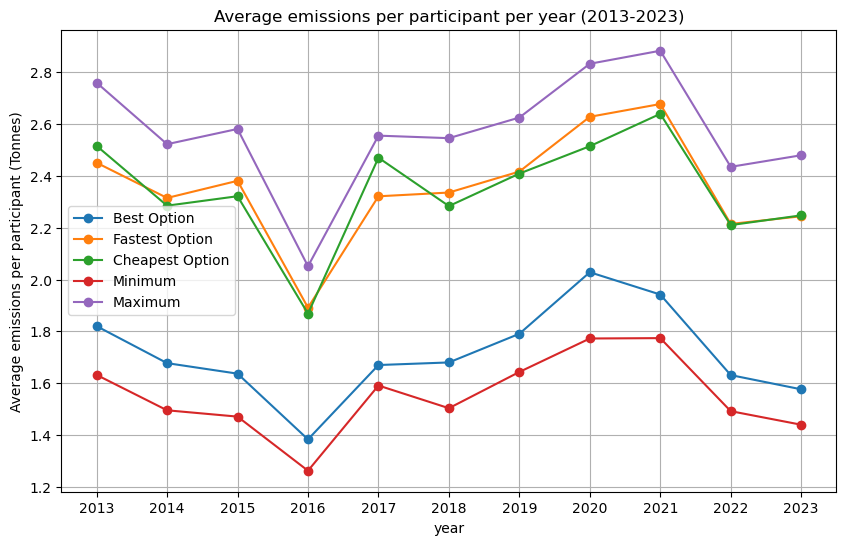

In [46]:
plt.figure(figsize=(10, 6))

plt.plot(average_emissions_per_participant_df2['year'], 
         average_emissions_per_participant_df2['average_best_emis_per_participant'], 
         marker='o', label='Best Option')

plt.plot(average_emissions_per_participant_df2['year'], 
         average_emissions_per_participant_df2['average_fastest_emis_per_participant'], 
         marker='o', label='Fastest Option')

plt.plot(average_emissions_per_participant_df2['year'], 
         average_emissions_per_participant_df2['average_cheapest_emis_per_participant'], 
         marker='o', label='Cheapest Option')

plt.plot(average_emissions_per_participant_df2['year'], 
         average_emissions_per_participant_df2['average_min_emis_per_participant'], 
         marker='o', label='Minimum')

plt.plot(average_emissions_per_participant_df2['year'], 
         average_emissions_per_participant_df2['average_max_emis_per_participant'], 
         marker='o', label='Maximum')

plt.xlabel('year')
plt.ylabel('Average emissions per participant (Tonnes)')
plt.title('Average emissions per participant per year (2013-2023)')
plt.xticks(average_emissions_per_participant_df2['year'])
plt.legend()
plt.grid(True)
plt.show()

### 3. Geographic data for academic travel

#### 3.1 Top10 original and destination countries and cities 

In [47]:
df3 = df2.copy()

In [48]:
top_10_country_origin = df3['country_eng_origin'].value_counts().head(10)
top_10_city_origin = df3['city_eng_origin'].value_counts().head(10)
top_10_country_dest = df3['country_eng_dest'].value_counts().head(10)
top_10_city_dest = df3['city_eng_dest'].value_counts().head(10)

/tmp/ipykernel_14663/3597338594.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 0].set_xticklabels(top_10_country_origin.index, rotation=45, ha="right")
/tmp/ipykernel_14663/3597338594.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 1].set_xticklabels(top_10_city_origin.index, rotation=45, ha="right")
/tmp/ipykernel_14663/3597338594.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 0].set_xticklabels(top_10_country_dest.index, rotation=45, ha="right")
/tmp/ipykernel_14663/3597338594.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 1].set_xticklabels(top_10_city_dest.index, rotation=45, ha="right")


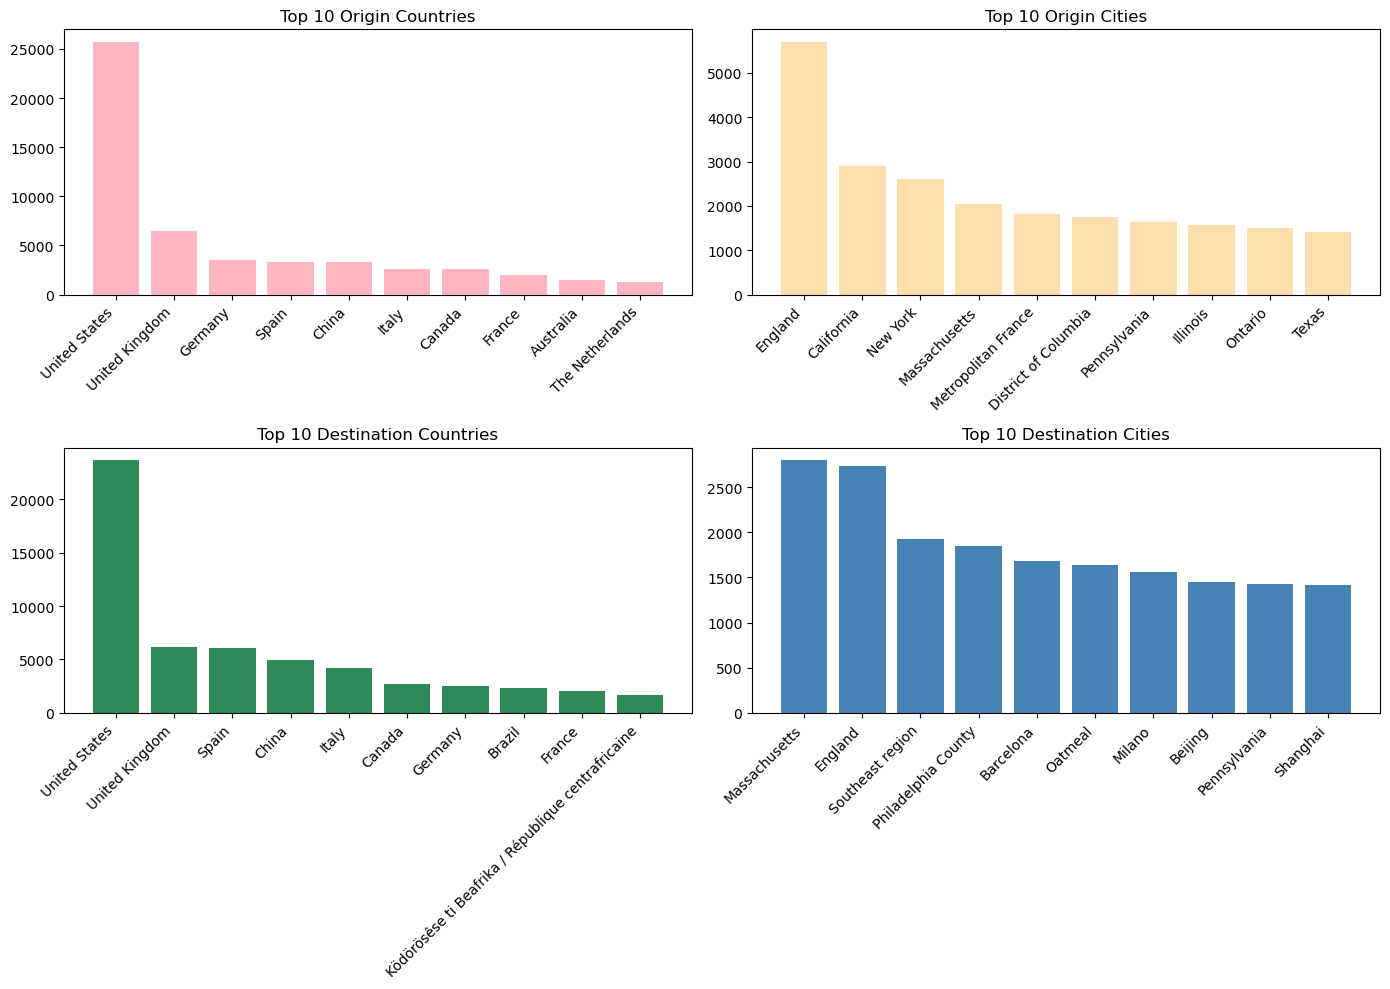

In [49]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10)) 

colors = ['#FFB6C1', '#FFDEAD', '#2E8B57', '#4682B4']

axs[0, 0].bar(top_10_country_origin.index, top_10_country_origin.values, color=colors[0])
axs[0, 0].set_title('Top 10 Origin Countries')
axs[0, 0].set_xticklabels(top_10_country_origin.index, rotation=45, ha="right")

axs[0, 1].bar(top_10_city_origin.index, top_10_city_origin.values, color=colors[1])
axs[0, 1].set_title('Top 10 Origin Cities')
axs[0, 1].set_xticklabels(top_10_city_origin.index, rotation=45, ha="right")

axs[1, 0].bar(top_10_country_dest.index, top_10_country_dest.values, color=colors[2])
axs[1, 0].set_title('Top 10 Destination Countries')
axs[1, 0].set_xticklabels(top_10_country_dest.index, rotation=45, ha="right")

axs[1, 1].bar(top_10_city_dest.index, top_10_city_dest.values, color=colors[3])
axs[1, 1].set_title('Top 10 Destination Cities')
axs[1, 1].set_xticklabels(top_10_city_dest.index, rotation=45, ha="right")

plt.tight_layout()
plt.show()

In [50]:
count_us_origin = df3[df3['country_eng_origin'] == 'United States'].shape[0]

total_trips = df3['country_eng_origin'].shape[0]

us_origin_percentage = (count_us_origin / total_trips) * 100

print(f'Number of trips from the US: {count_us_origin}')
print(f'Total number of trips: {total_trips}')
print(f'Percentage of trips from the US: {us_origin_percentage:.2f}%')


Number of trips from the US: 25700
Total number of trips: 69723
Percentage of trips from the US: 36.86%


In [51]:
us_participants = df3[df3['country_eng_origin'] == 'United States']['name'].nunique()

total_participants = df3['name'].nunique()

us_percentage = (us_participants / total_participants) * 100

print(f'Number of unique participants from the US: {us_participants}')
print(f'Total number of unique participants: {total_participants}')
print(f'Percentage of participants from the US: {us_percentage:.2f}%')


Number of unique participants from the US: 8860
Total number of unique participants: 24747
Percentage of participants from the US: 35.80%


In [52]:
count_uk_origin = df3[df3['country_eng_origin'] == 'United Kingdom'].shape[0]

total_trips = df3['country_eng_origin'].shape[0]

uk_origin_percentage = (count_uk_origin / total_trips) * 100

print(f'Number of trips from the UK: {count_uk_origin}')
print(f'Total number of trips: {total_trips}')
print(f'Percentage of trips from the UK: {uk_origin_percentage:.2f}%')


Number of trips from the UK: 6439
Total number of trips: 69723
Percentage of trips from the UK: 9.24%


In [53]:
uk_participants = df3[df3['country_eng_origin'] == 'United Kingdom']['name'].nunique()

total_participants = df3['name'].nunique()

uk_percentage = (uk_participants / total_participants) * 100

print(f'Number of unique participants from the UK: {uk_participants}')
print(f'Total number of unique participants: {total_participants}')
print(f'Percentage of participants from the UK: {uk_percentage:.2f}%')


Number of unique participants from the UK: 2568
Total number of unique participants: 24747
Percentage of participants from the UK: 10.38%


In [54]:
us_dest = df3[df3['country_eng_dest'] == 'United States']['conf_name_alt'].nunique()

total_conf = df3['conf_name_alt'].nunique()

us_dest_percentage = (us_dest / total_conf) * 100

print(f'Number of conference hold in the US: {us_dest}')
print(f'Total number of conferencs: {total_conf}')
print(f'Percentage of conference hold in the US: {us_dest_percentage:.2f}%')

Number of conference hold in the US: 114
Total number of conferencs: 369
Percentage of conference hold in the US: 30.89%


In [55]:
uk_dest = df3[df3['country_eng_dest'] == 'United Kingdom']['conf_name_alt'].nunique()

total_conf = df3['conf_name_alt'].nunique()

uk_dest_percentage = (uk_dest / total_conf) * 100

print(f'Number of conference hold in the UK: {uk_dest}')
print(f'Total number of conferencs: {total_conf}')
print(f'Percentage of conference hold in the UK: {uk_dest_percentage:.2f}%')

Number of conference hold in the UK: 31
Total number of conferencs: 369
Percentage of conference hold in the UK: 8.40%


#### 3.2 Academic conference maps by region

In [56]:
pip install pandas pycountry_convert

Note: you may need to restart the kernel to use updated packages.


In [57]:
import pycountry_convert as pc

def iso3_to_continent(iso3):
    try:
        iso2 = pc.country_alpha3_to_country_alpha2(iso3)
        continent_code = pc.country_alpha2_to_continent_code(iso2)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except:
        return "Unknown"

df3['continent_origin'] = df3['iso3_origin'].apply(iso3_to_continent)
df3['continent_dest'] = df3['iso3_dest'].apply(iso3_to_continent)

continent_to_region = {
    'Asia': 'Asia',
    'Europe': 'Europe',  
    'Africa': 'Africa',
    'North America': 'Northern America',  
    'South America': 'Latin America and the Caribbean',  
    'Central America': 'Latin America and the Caribbean',  
    'Caribbean': 'Latin America and the Caribbean',  
    'Australia': 'Oceania', 
    'Oceania': 'Oceania',  
    'Antarctica': 'Others',
    'Unknown': 'Others'
}


def country_to_subregion(iso3):
    try:
        iso2 = pc.country_alpha3_to_country_alpha2(iso3)
        subregion = pc.country_alpha2_to_subregion(iso2)
        return subregion
    except:
        return "Unknown"

df3['subregion_origin'] = df3['iso3_origin'].apply(country_to_subregion)
df3['subregion_dest'] = df3['iso3_dest'].apply(country_to_subregion)


df3['region_origin'] = df3['continent_origin'].apply(lambda x: continent_to_region[x] if x in continent_to_region else continent_to_region[country_to_subregion(x)])
df3['region_dest'] = df3['continent_dest'].apply(lambda x: continent_to_region[x] if x in continent_to_region else continent_to_region[country_to_subregion(x)])

df3['region_origin'].info()
df3['region_dest'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 69723 entries, 0 to 69722
Series name: region_origin
Non-Null Count  Dtype 
--------------  ----- 
69723 non-null  object
dtypes: object(1)
memory usage: 544.8+ KB
<class 'pandas.core.series.Series'>
RangeIndex: 69723 entries, 0 to 69722
Series name: region_dest
Non-Null Count  Dtype 
--------------  ----- 
69723 non-null  object
dtypes: object(1)
memory usage: 544.8+ KB


In [58]:
region_origin_counts = df3['region_origin'].value_counts()
region_dest_counts = df3['region_dest'].value_counts()

print(region_origin_counts)
print(region_dest_counts)

region_origin
Northern America                   28472
Europe                             23026
Asia                                7433
Others                              6368
Latin America and the Caribbean     1965
Oceania                             1496
Africa                               963
Name: count, dtype: int64
region_dest
Northern America                   26748
Europe                             26426
Asia                                9060
Latin America and the Caribbean     3559
Others                              3117
Oceania                              629
Africa                               184
Name: count, dtype: int64


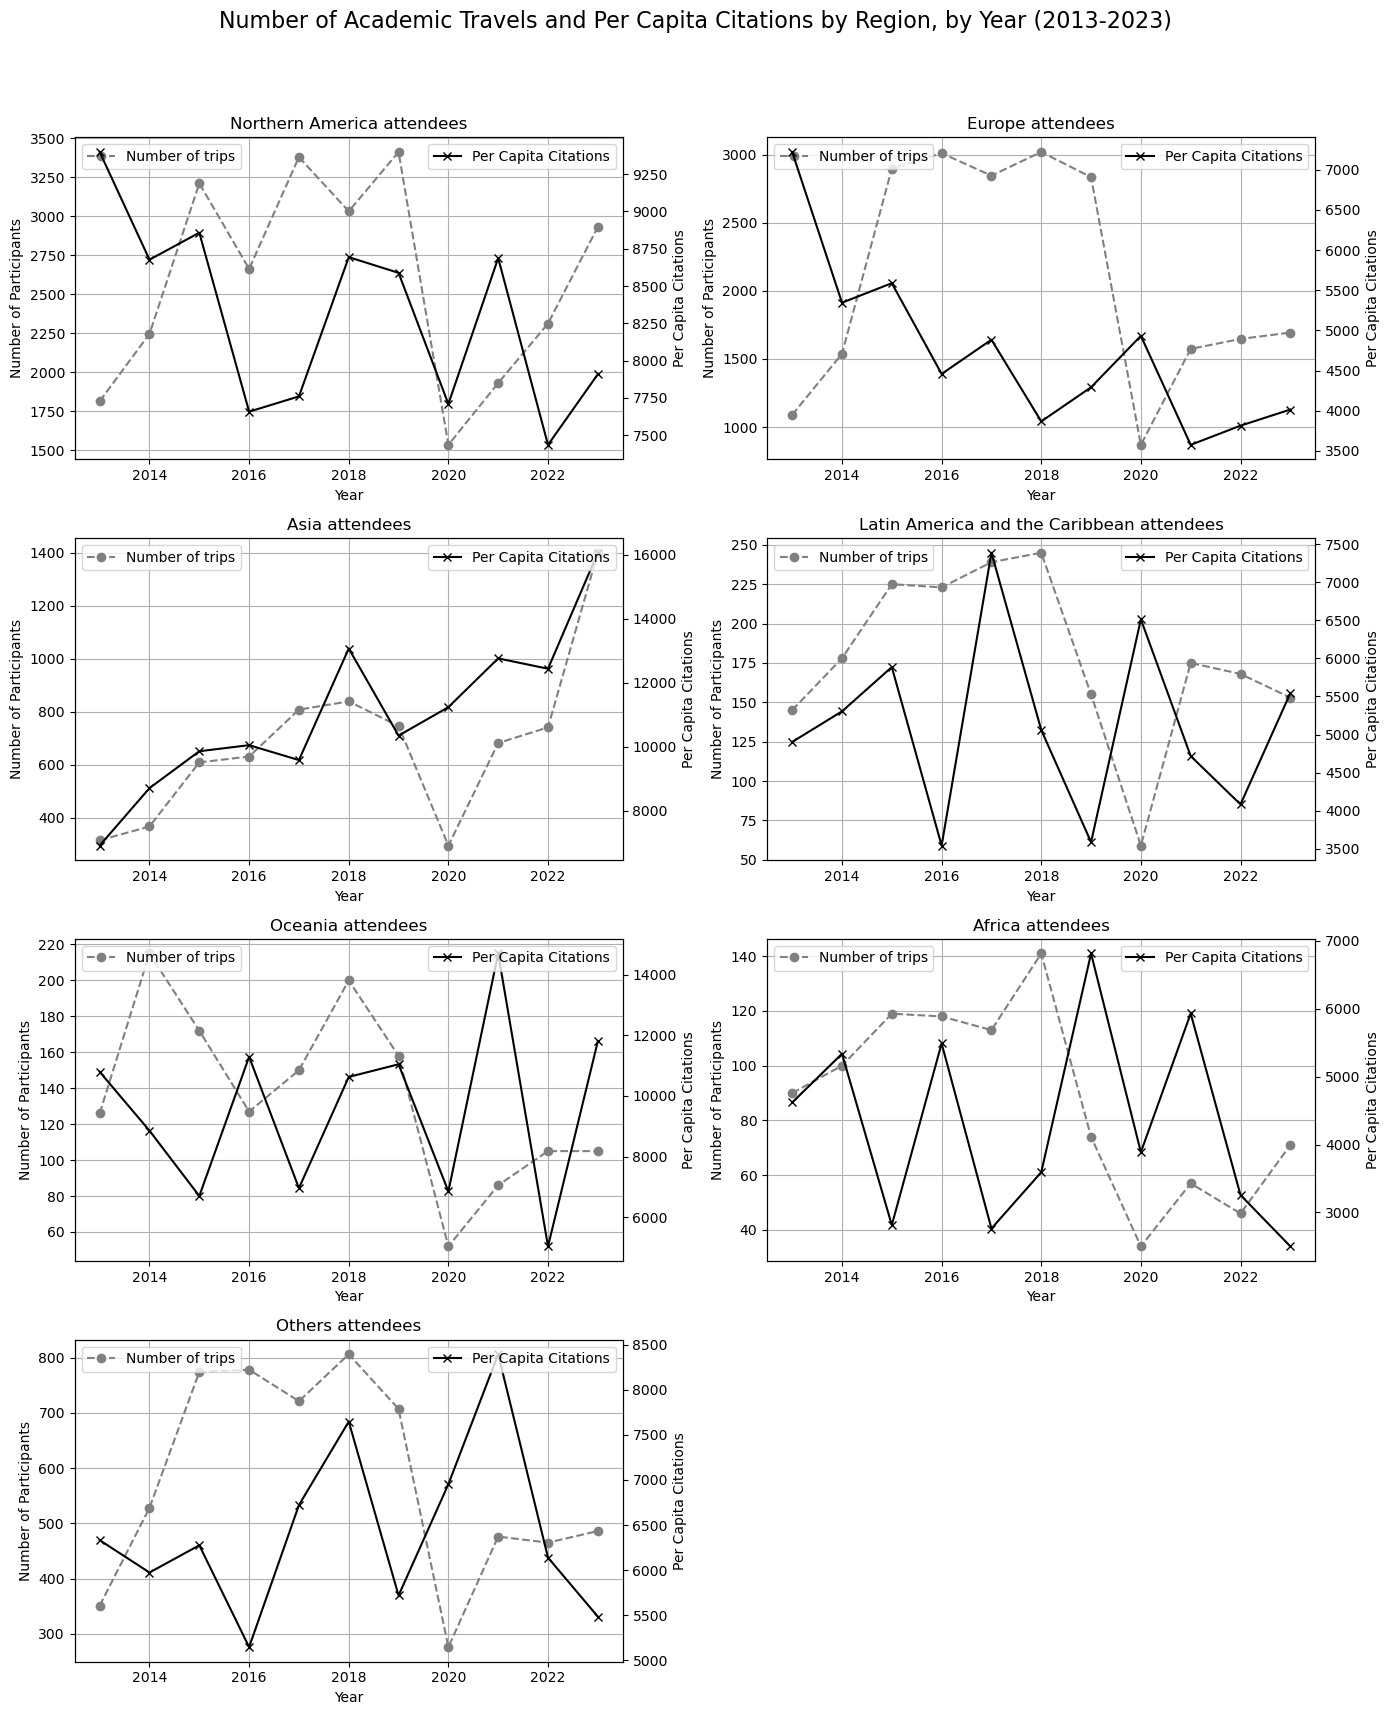

In [59]:
regions = ['Northern America', 'Europe', 'Asia', 'Latin America and the Caribbean', 'Oceania', 'Africa', 'Others']
n_cols = 2
n_rows = (len(regions) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 18))
axes = axes.flatten() 

for i, region in enumerate(regions):
    ax = axes[i]
    data = df3[df3['region_origin'] == region]

    yearly_data = data.groupby('year').agg({
        'name': 'size',  
        'citations': 'sum'
    })

    yearly_data['per_capita_citations'] = yearly_data['citations'] / yearly_data['name']

    ax.plot(yearly_data.index, yearly_data['name'], color='gray', linestyle='--', marker='o', label='Number of trips')

    ax2 = ax.twinx()
    ax2.plot(yearly_data.index, yearly_data['per_capita_citations'], color='black', linestyle='-', marker='x', label='Per Capita Citations')

    ax.set_title(f'{region} attendees')
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of Participants')
    ax2.set_ylabel('Per Capita Citations')

    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    ax2.get_yaxis().get_major_formatter().set_scientific(False)

    ax.grid(True)
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle('Number of Academic Travels and Per Capita Citations by Region, by Year (2013-2023)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [60]:
conf_venue = df3.groupby('country_eng_dest').agg({
    'conf_name_alt': pd.Series.nunique, 
    'name': 'size' 
}).rename(columns={
    'conf_name_alt': 'Number of conferences',
    'name': 'Number of trips'
}).reset_index()

conf_venue

,country_eng_dest,Number of conferences,Number of trips
0,Australia,7,629
1,Austria,2,257
2,België / Belgium / Belgian,1,208
3,Brazil,11,2317
4,Canada,8,2662
5,Chile,11,818
6,China,16,4941
7,Colombia,1,358
8,Cyprus,1,334
9,Czechia,1,78


In [61]:
df3['conf_name_alt'].count()

69723

In [62]:
unique_continents = df3['continent_dest'].unique()

for continent in unique_continents:
    print(continent)

North America
Europe
Africa
Asia
Oceania
South America
Unknown


In [63]:
unique_region = df3['region_dest'].unique()

for region in unique_region:
    print(region)

Northern America
Europe
Africa
Asia
Oceania
Latin America and the Caribbean
Others


In [64]:
pivot_table = pd.crosstab(df3['region_dest'], df3['region_origin'], margins=True, margins_name='Total')

order = ['Northern America', 'Europe', 'Asia', 'Latin America and the Caribbean', 'Oceania', 'Africa', 'Others','Total']
pivot_table = pivot_table.reindex(index=order, columns=order, fill_value=0)

pivot_table.columns.name = "Attendees"
pivot_table.index.name = "Venue"
pivot_table

Attendees,Northern America,Europe,Asia,Latin America and the Caribbean,Oceania,Africa,Others,Total
Venue,,,,,,,,
Northern America,18179,4480,1546,311,306,269,1657,26748
Europe,5391,15039,1462,519,388,346,3281,26426
Asia,2802,1325,3893,52,338,44,606,9060
Latin America and the Caribbean,1178,627,278,1046,41,38,351,3559
Oceania,110,45,90,8,320,6,50,629
Africa,63,39,17,3,6,39,17,184
Others,749,1471,147,26,97,221,406,3117
Total,28472,23026,7433,1965,1496,963,6368,69723


In [65]:
pivot_region_presented = pd.crosstab(df3['region_origin'], df3['region_dest'], margins=False)

percentage_region_presented = pivot_region_presented.div(pivot_region_presented.sum(axis=1), axis=0)
percentage_region_presented = percentage_region_presented.round(3)

percentage_region_presented = percentage_region_presented.reindex(index=order, columns=order, fill_value=0)

percentage_region_presented.columns.name = "Origin"
percentage_region_presented.index.name = "Venue"

print("Percentage of attendees at conferences by attendee and venue (continent) (row sum to 1):")
percentage_region_presented

Percentage of attendees at conferences by attendee and venue (continent) (row sum to 1):


Origin,Northern America,Europe,Asia,Latin America and the Caribbean,Oceania,Africa,Others,Total
Venue,,,,,,,,
Northern America,0.638,0.189,0.098,0.041,0.004,0.002,0.026,0.0
Europe,0.195,0.653,0.058,0.027,0.002,0.002,0.064,0.0
Asia,0.208,0.197,0.524,0.037,0.012,0.002,0.020,0.0
Latin America and the Caribbean,0.158,0.264,0.026,0.532,0.004,0.002,0.013,0.0
Oceania,0.205,0.259,0.226,0.027,0.214,0.004,0.065,0.0
Africa,0.279,0.359,0.046,0.039,0.006,0.040,0.229,0.0
Others,0.260,0.515,0.095,0.055,0.008,0.003,0.064,0.0
Total,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0


### 3.3 find the culprit of emission

**Emission**</p>
df3['best_opt_emission']  # emission per trip estimated by 'best_opt_time' and 'best_opt_transport'</p>
df3['best_opt_transport']</p>
df3['best_opt_time']</p>
df3['best_opt_price']     # price and time per trip</p>

emission for each conference can be calculated.

**attendee features**</p>

df3['citations']</p>
df3['first_publication_year']</p>

**Geographic data -- origin and venue**</p> 

df3['iso3_origin']</p>
df3['iso3_dest'] </p> 

df3['region_origin'] # 6 continents</p>
df3['region_dest']</p>

df3['city_eng_origin']</p>
df3['city_eng_dest']  # city</p>

df3['country_eng_origin']</p>
df3['country_eng_dest']  #country


**geographic data**</p>

latitude, longitude of city (need to extract from city_eng_origion, city_eng_dest)


In [66]:
# emission per conference

df3['conf_emis'] = df3.groupby('conf_name_alt')['best_opt_emission'].transform('sum')

print(df3[['conf_name_alt', 'conf_emis']].drop_duplicates())

                                           conf_name_alt   conf_emis
0      CSAE Conference 2013: Economic Development in ...  909.748291
181    Society for Nonlinear Dynamics and Econometric...  149.727170
259      Midwest Economic Theory Conference, Spring 2013   46.267497
305    Midwest International Trade Conference, Spring...   52.409417
336                           2013 Midwest Macro Meeting  167.677816
...                                                  ...         ...
53388  Politiques Publiques et évidences scientifique...    9.090267
53401  Hong Kong Economic Association Biennial Confer...   84.044943
53488                          Annual Winter School 2023   61.261580
53546  Asia-Pacific Industrial Organisation Conferenc...  127.214472
53629  European winter meeting of The Econometric Soc...  272.855686

[369 rows x 2 columns]


#### K-means Clustering

In [67]:
df4 = df3.copy()

In [102]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

features = ['citations', 'best_opt_emission', 'best_opt_time', 'best_opt_price']

df4_cleaned = df4.dropna(subset=features)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df4_cleaned[features ])

# 假设选择3个簇
kmeans = KMeans(n_clusters=3, random_state=42)
df4_cleaned['cluster'] = kmeans.fit_predict(scaled_features)

print(df4_cleaned[['conf_name_alt', 'cluster']])

/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


                                           conf_name_alt  cluster
0      CSAE Conference 2013: Economic Development in ...        0
1      CSAE Conference 2013: Economic Development in ...        0
2      CSAE Conference 2013: Economic Development in ...        1
3      CSAE Conference 2013: Economic Development in ...        0
4      CSAE Conference 2013: Economic Development in ...        0
...                                                  ...      ...
69718               Jornadas de Economía Industrial 2023        1
69719               Jornadas de Economía Industrial 2023        1
69720  17th North American Meeting of the Urban Econo...        0
69721  17th North American Meeting of the Urban Econo...        1
69722  North East Universities Development Consortium...        0

[69363 rows x 2 columns]


/tmp/ipykernel_14663/4998394.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4_cleaned['cluster'] = kmeans.fit_predict(scaled_features)


In [103]:
df4_cleaned.loc[:, 'cluster'] = kmeans.fit_predict(scaled_features)

/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


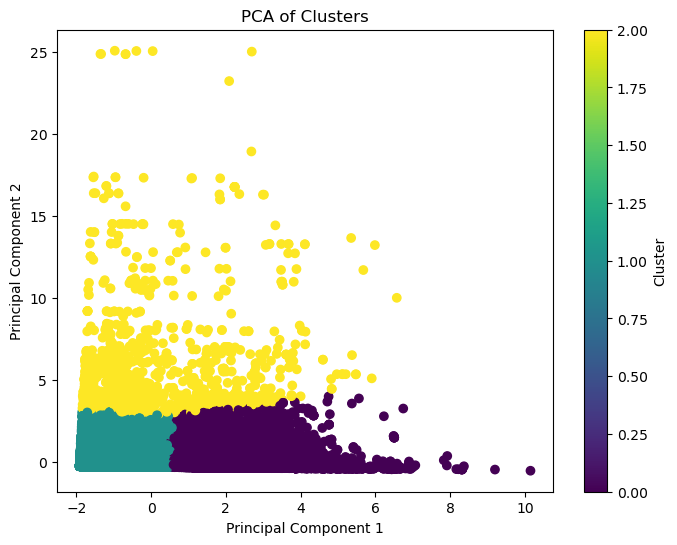

In [104]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PCA (dimensionality reduction)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)


plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=df4_cleaned['cluster'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Clusters')
plt.colorbar(label='Cluster')
plt.show()

In [105]:
from sklearn.metrics import silhouette_score

# Silhouette Score
sil_score = silhouette_score(scaled_features, df4_cleaned['cluster'])
print(f'Silhouette Score: {sil_score}')

Silhouette Score: 0.5395065665594018


/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

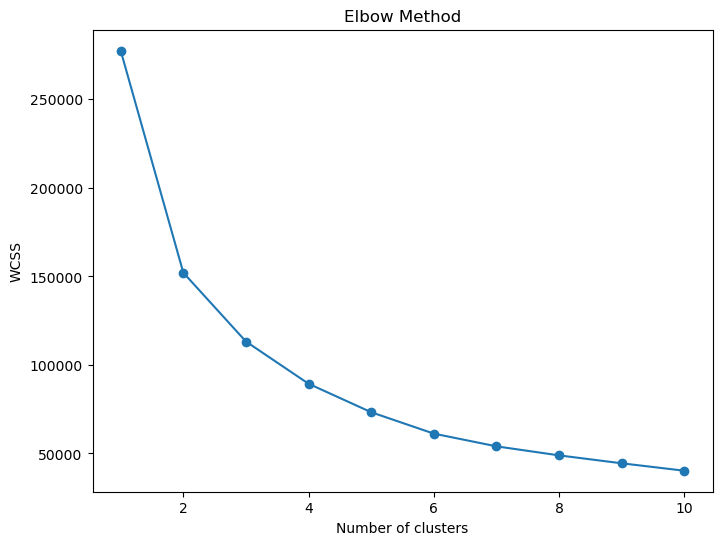

In [106]:
wcss = []  # Within-cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [107]:

cluster_counts = df4_cleaned['cluster'].value_counts()

cluster_percentages = cluster_counts / len(df4_cleaned) * 100

print("Cluster Counts:\n", cluster_counts)
print("\nCluster Percentages:\n", cluster_percentages)


Cluster Counts:
 cluster
1    46769
0    21473
2     1121
Name: count, dtype: int64

Cluster Percentages:
 cluster
1    67.426438
0    30.957427
2     1.616135
Name: count, dtype: float64


In [110]:
cluster_emission_means = df4_cleaned.groupby('cluster')['best_opt_emission'].mean()

print("Mean best_opt_emission by Cluster:\n", cluster_emission_means)

Mean best_opt_emission by Cluster:
 cluster
0    3.777332
1    0.722133
2    1.673353
Name: best_opt_emission, dtype: float64


/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


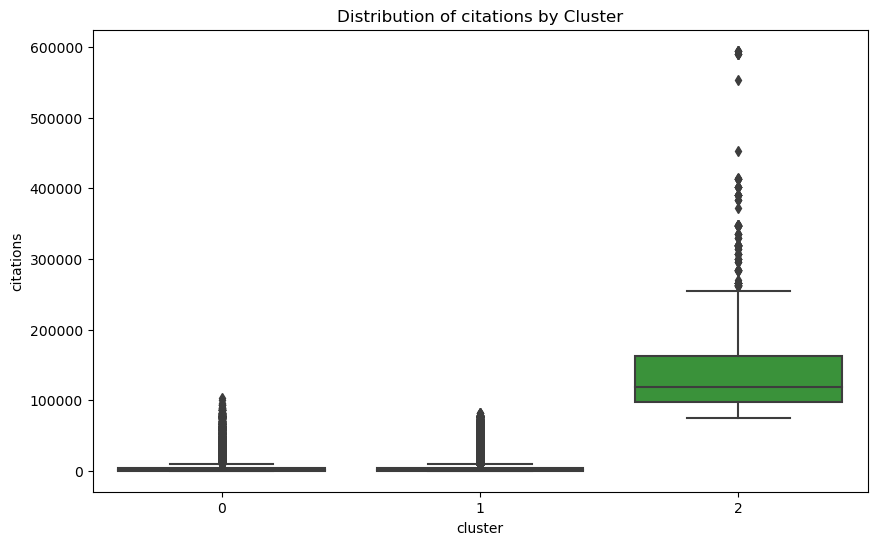

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


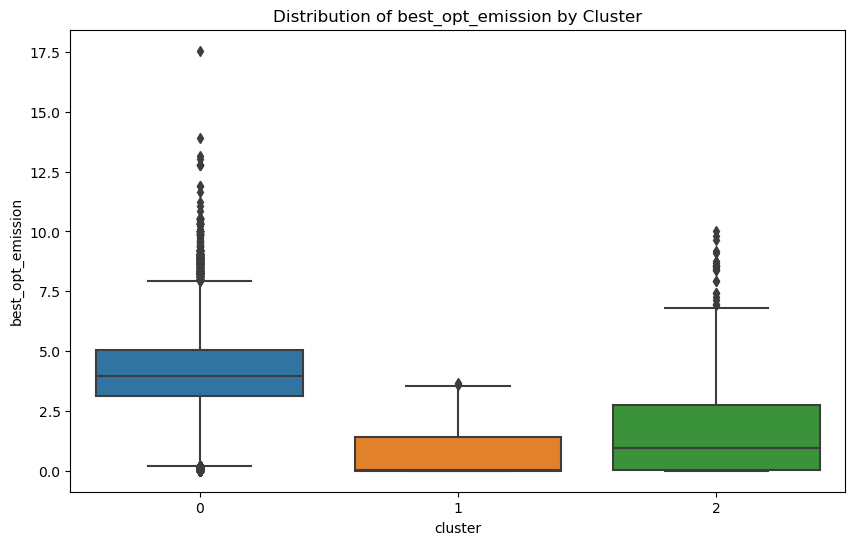

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


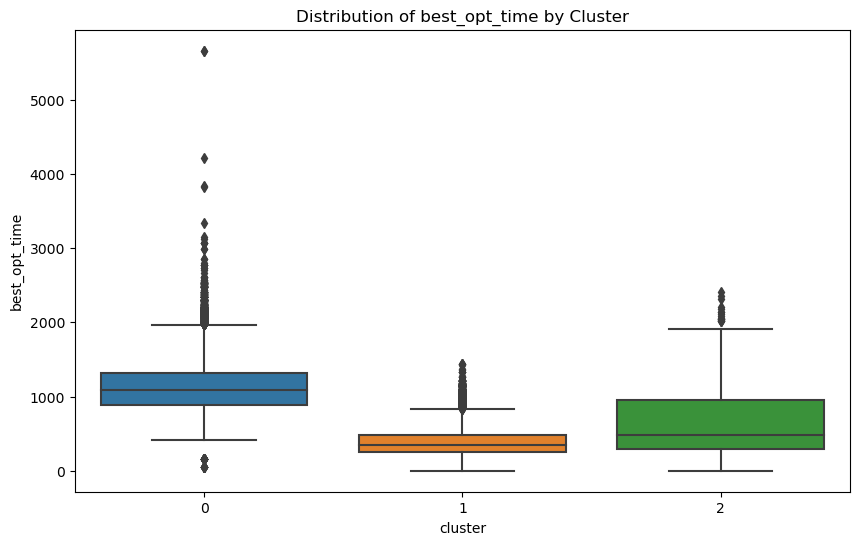

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


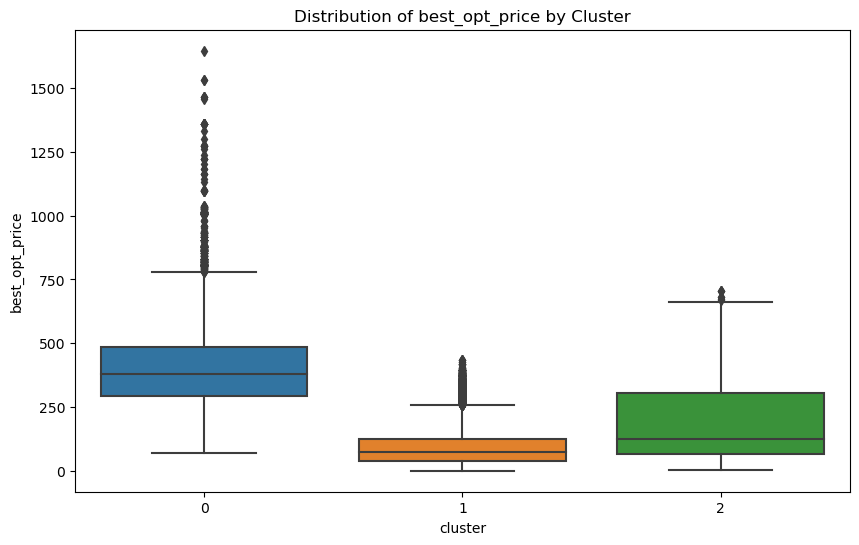

In [112]:
# 绘制各簇中主要特征的分布
for feature in ['citations', 'best_opt_emission', 'best_opt_time', 'best_opt_price']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='cluster', y=feature, data=df4_cleaned)
    plt.title(f'Distribution of {feature} by Cluster')
    plt.show()

In [113]:
# high emission cluster

high_emission_samples = df4_cleaned[df4_cleaned['cluster'] == 0]

print(high_emission_samples.head())  

                    name  citations  first_publication_year  is_presenter  \
0     Matthieu Delpierre      171.0                  2005.0             1   
1          Daniel Clarke     2467.0                  1986.0             1   
3         Julie Subervie     1373.0                  2006.0             1   
4        Matthew Adewumi     1246.0                  1993.0             1   
5  Chitalu Chama-Chiliba      451.0                  2009.0             1   

   year                                              link  \
0  2013  https://editorialexpress.com/conference/CSAE2013   
1  2013  https://editorialexpress.com/conference/CSAE2013   
3  2013  https://editorialexpress.com/conference/CSAE2013   
4  2013  https://editorialexpress.com/conference/CSAE2013   
5  2013  https://editorialexpress.com/conference/CSAE2013   

                                           conf_name  \
0  CSAE Conference 2013: Economic Development in ...   
1  CSAE Conference 2013: Economic Development in ...   
3 

In [118]:
# citation
citation_mean = high_emission_samples['citations'].mean()

citation_min = high_emission_samples['citations'].min()
citation_max = high_emission_samples['citations'].max()

print(f"Citation Mean in High Emission Cluster: {citation_mean}")
print(f"Citation Range in High Emission Cluster: {citation_min} - {citation_max}")


Citation Mean in High Emission Cluster: 5236.751269035533
Citation Range in High Emission Cluster: 1.0 - 102906.0


In [119]:
# price
price_mean = high_emission_samples['best_opt_price'].mean()

price_min = high_emission_samples['best_opt_price'].min()
price_max = high_emission_samples['best_opt_price'].max()

print(f"Price Mean in High Emission Cluster: {price_mean}")
print(f"Price Range in High Emission Cluster: {price_min} - {price_max}")

Price Mean in High Emission Cluster: 398.00405159968335
Price Range in High Emission Cluster: 69.0 - 1647.0


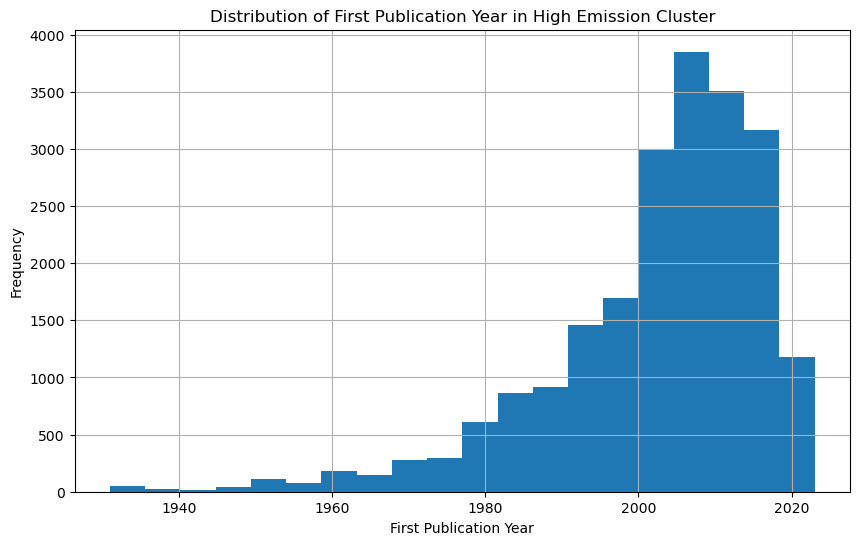

In [120]:
# Distribution of the first publication year in high emission cluster

plt.figure(figsize=(10, 6))
high_emission_samples['first_publication_year'].hist(bins=20)
plt.title("Distribution of First Publication Year in High Emission Cluster")
plt.xlabel("First Publication Year")
plt.ylabel("Frequency")
plt.show()

In [121]:
# region_origion
region_origin_dist = high_emission_samples['region_origin'].value_counts()

# region_dest
region_dest_dist = high_emission_samples['region_dest'].value_counts()

print("Region Origin Distribution in High Emission Cluster:\n", region_origin_dist)
print("\nRegion Destination Distribution in High Emission Cluster:\n", region_dest_dist)

Region Origin Distribution in High Emission Cluster:
 region_origin
Northern America                   8599
Europe                             5515
Asia                               2930
Others                             1858
Oceania                            1044
Latin America and the Caribbean     940
Africa                              587
Name: count, dtype: int64

Region Destination Distribution in High Emission Cluster:
 region_dest
Northern America                   7343
Europe                             5841
Asia                               4387
Others                             2062
Latin America and the Caribbean    1491
Oceania                             219
Africa                              130
Name: count, dtype: int64


In [136]:
pivot_table = pd.crosstab(high_emission_samples['region_dest'], high_emission_samples['region_origin'], margins=True, margins_name='Total')

order = ['Northern America', 'Europe', 'Asia', 'Latin America and the Caribbean', 'Oceania', 'Africa', 'Others','Total']
pivot_table = pivot_table.reindex(index=order, columns=order, fill_value=0)

pivot_table.columns.name = "Attendees in high emission cluster"
pivot_table.index.name = "Venue in high emission cluster"
pivot_table

Attendees in high emission cluster,Northern America,Europe,Asia,Latin America and the Caribbean,Oceania,Africa,Others,Total
Venue in high emission cluster,,,,,,,,
Northern America,1550,2885,1424,234,286,192,772,7343
Europe,3363,315,921,405,370,112,355,5841
Asia,2665,914,140,48,277,29,314,4387
Latin America and the Caribbean,202,533,270,219,40,28,199,1491
Oceania,107,38,48,8,0,3,15,219
Africa,59,27,13,3,6,10,12,130
Others,653,803,114,23,65,213,191,2062
Total,8599,5515,2930,940,1044,587,1858,21473


In [124]:
transport = high_emission_samples['best_opt_transport'].value_counts()
print("Transport modes in High Emission Cluster:\n", transport)

Transport modes in High Emission Cluster:
 best_opt_transport
Fly           17465
Train          2081
Bus             831
Taxi            395
Subway          244
Drive           174
Shuttle         107
BART             67
Night            53
Caltrain         25
Helicopter       11
Ferry             6
Car               4
Towncar           3
Tram              3
Travel            2
Metro             2
Name: count, dtype: int64


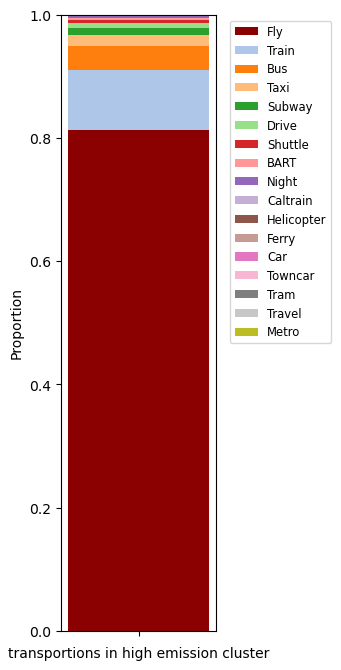

In [135]:
transport_data = {
    'Fly': 17465,
    'Train': 2081,
    'Bus': 831,
    'Taxi': 395,
    'Subway': 244,
    'Drive': 174,
    'Shuttle': 107,
    'BART': 67,
    'Night': 53,
    'Caltrain': 25,
    'Helicopter': 11,
    'Ferry': 6,
    'Car': 4,
    'Towncar': 3,
    'Tram': 3,
    'Travel': 2,
    'Metro': 2
}

transport_modes = list(transport_data.keys())
counts = list(transport_data.values())

proportions = [count / sum(counts) for count in counts]

colors = ['darkred'] + list(plt.cm.tab20.colors[1:len(transport_modes)])

plt.figure(figsize=(2, 8))
bars = plt.bar(
    [0], 
    proportions, 
    bottom=pd.Series(proportions).cumsum() - proportions, 
    color=colors
)

plt.legend(bars, transport_modes, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

plt.xlabel('transportions in high emission cluster')
plt.ylabel('Proportion')
plt.ylim(0, 1) 
plt.xticks([0], ['']) 
plt.show()


#### Random Forest

In [73]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = scaled_features
y = df4_cleaned['best_opt_emission'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.0014506680818496239


In [90]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


#features


# 1. log transformation
df4['log_citation'] = np.log1p(df4['citations'])
df4['log_emission'] = np.log1p(df4['best_opt_emission'])
df4['log_price'] = np.log1p(df4['best_opt_price'])
df4['log_time'] = np.log1p(df4['best_opt_time'])

# 2. One-Hot Encoding for region_origin and region_dest
ohe = OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False)
geo_features = ['region_origin', 'region_dest']

# 3. Binary characteristics of the same country or different countries
df4['same_country'] = (df4['iso3_origin'] == df4['iso3_dest']).astype(int)



preprocessor = ColumnTransformer(
    transformers=[
        ('geo', ohe, geo_features),
        ('scaler', StandardScaler(), ['log_time', 'log_price', 'log_citation', 'same_country'])
    ]
)


In [93]:

X = preprocessor.fit_transform(df4_1)
y = df4_1['log_emission']


print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')


df4_1 = df4.dropna(subset=['log_emission', 'region_origin', 'region_dest', 'citations', 'best_opt_emission', 'best_opt_price', 'best_opt_time'])


X = preprocessor.fit_transform(df4_1)
y = df4_1['log_emission']


print(f'Cleaned X shape: {X.shape}')
print(f'Cleaned y shape: {y.shape}')


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


X shape: (69363, 16)
y shape: (69363,)
Cleaned X shape: (69363, 16)
Cleaned y shape: (69363,)
Mean Squared Error: 0.1394197498420228


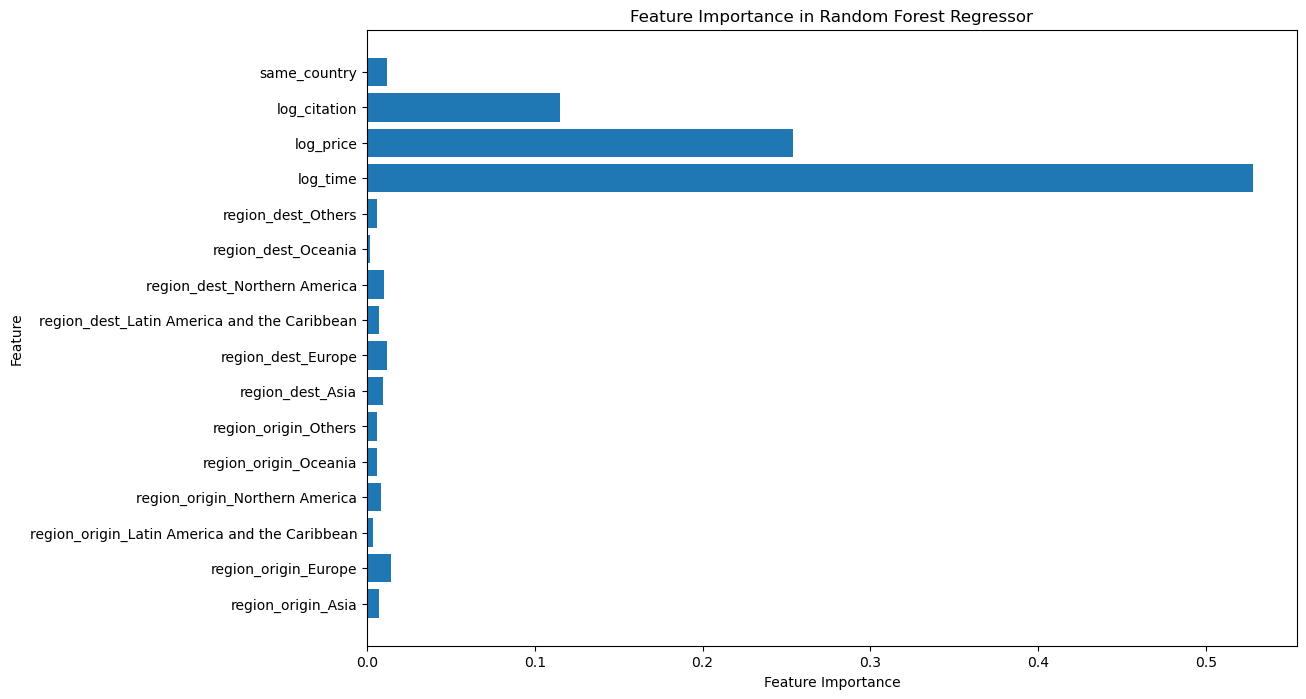

In [94]:

#  feature importance
feature_importances = model.feature_importances_
encoded_feature_names = preprocessor.named_transformers_['geo'].get_feature_names_out(geo_features)
all_features = list(encoded_feature_names) + ['log_time', 'log_price', 'log_citation', 'same_country']


plt.figure(figsize=(12, 8))
plt.barh(all_features, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Regressor')
plt.show()

Mean Squared Error (MSE): 0.1394197498420228
R² Score: 0.7226064067529677


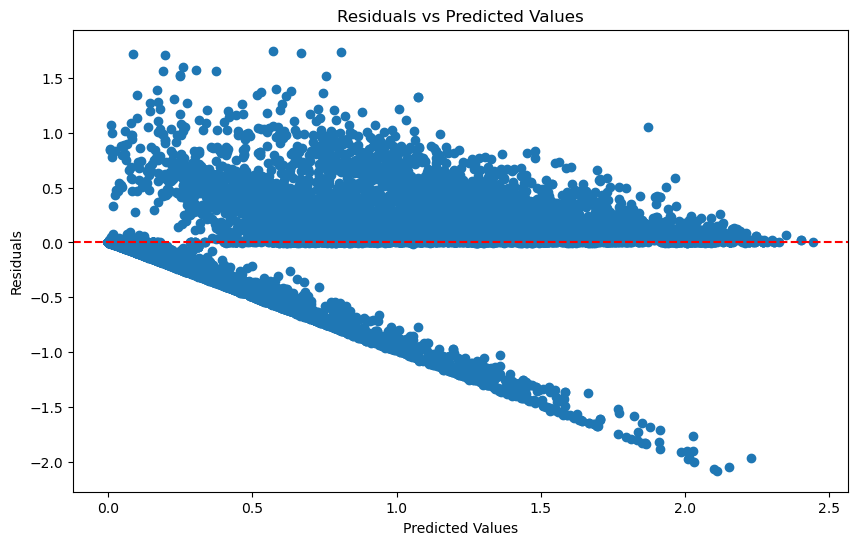

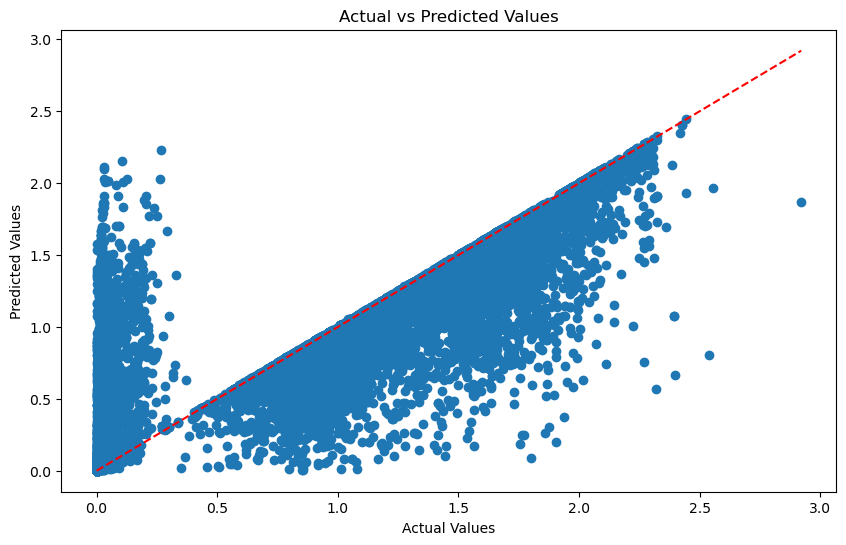

In [95]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# predict
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')


r2 = r2_score(y_test, y_pred)
print(f'R² Score: {r2}')

residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()


In [96]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


param_grid = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [None, 10, 20, 30], 
    'min_samples_split': [2, 10, 20], 
    'min_samples_leaf': [1, 5, 10]  
}


rf = RandomForestRegressor(random_state=42)

# Adjust parameters using grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)


print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (MSE):", -grid_search.best_score_)

# prediction
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')


Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  20.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  20.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  21.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  14.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  36.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  36.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  15.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  38.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  12.7s
[CV] EN

/opt/conda/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  11.5s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  26.0s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  12.2s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  22.6s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  40.8s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  40.9s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  24.3s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  40.2s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  23.9s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=20, n_estimators=100; tot

/tmp/ipykernel_14663/3984778232.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4_1['log_citation'] = np.log1p(df4_1['citations'])
/tmp/ipykernel_14663/3984778232.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4_1['log_emission'] = np.log1p(df4_1['best_opt_emission'])
/tmp/ipykernel_14663/3984778232.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

Mean Squared Error (MSE): 0.1387552411840668


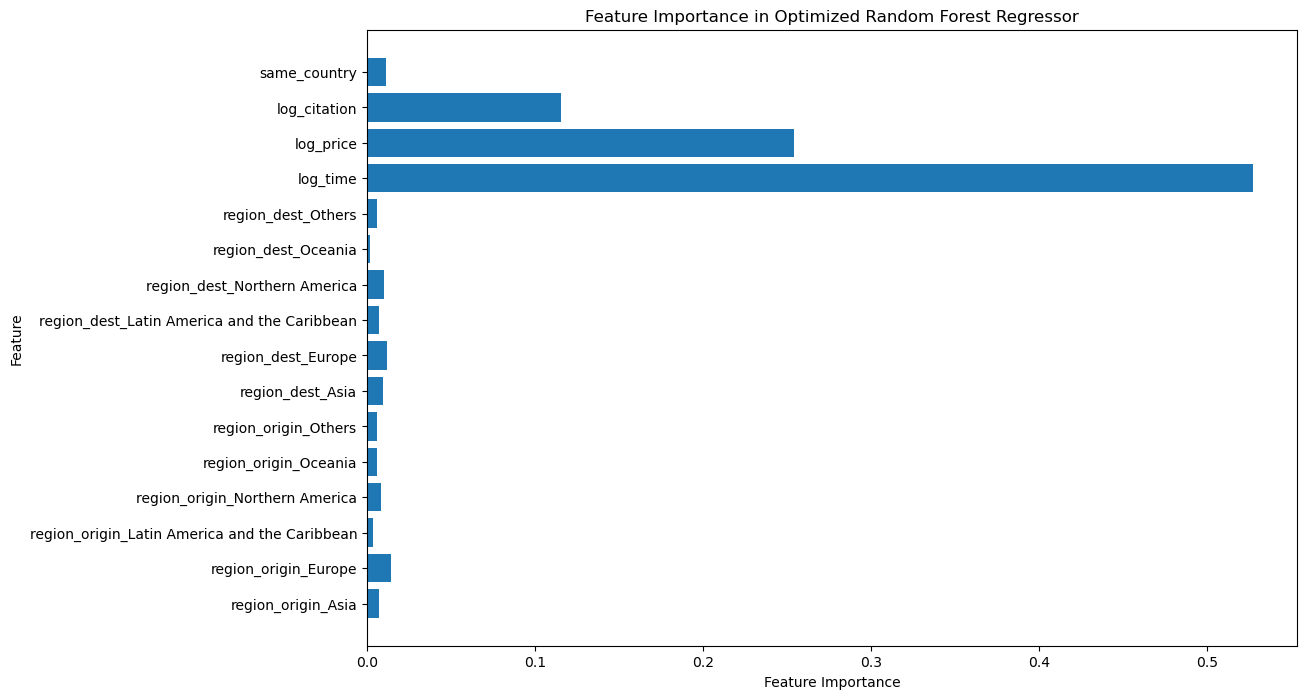

In [99]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error


df4_1['log_citation'] = np.log1p(df4_1['citations'])
df4_1['log_emission'] = np.log1p(df4_1['best_opt_emission'])
df4_1['log_price'] = np.log1p(df4_1['best_opt_price'])
df4_1['log_time'] = np.log1p(df4_1['best_opt_time'])


ohe = OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False)
geo_features = ['region_origin', 'region_dest']

preprocessor = ColumnTransformer(
    transformers=[
        ('geo', ohe, geo_features),
        ('scaler', StandardScaler(), ['log_time', 'log_price', 'log_citation', 'same_country'])
    ]
)

X = preprocessor.fit_transform(df4_1)
y = df4_1['log_emission']

# Use the best parameters to train the model
best_rf = RandomForestRegressor(n_estimators=300, max_depth=None, min_samples_leaf=1, min_samples_split=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
best_rf.fit(X_train, y_train)


y_pred = best_rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')


feature_importances = best_rf.feature_importances_
encoded_feature_names = preprocessor.named_transformers_['geo'].get_feature_names_out(geo_features)
all_features = list(encoded_feature_names) + ['log_time', 'log_price', 'log_citation', 'same_country']

plt.figure(figsize=(12, 8))
plt.barh(all_features, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Optimized Random Forest Regressor')
plt.show()


### 4. The case when people have a choice between train and flying

#### 4.1 First up, check out the time difference:

In [237]:
df5 = df4.copy()

In [253]:
#df5['cheapest_train_opt_price'] = pd.to_numeric(df5['cheapest_train_opt_price'], errors='coerce')
#df5['cheapest_flying_opt_price'] = pd.to_numeric(df5['cheapest_flying_opt_price'], errors='coerce')


valid_entries = df5.dropna(subset=['cheapest_train_opt_price', 'cheapest_flying_opt_price', 
                                   'cheapest_train_opt_time', 'cheapest_flying_opt_time',
                                   'cheapest_train_opt_transport', 'cheapest_flying_opt_transport'
                                  ])

valid_count = len(valid_entries)

print(f"Number of rows with valid values in both 'cheapest_train_opt_price' and 'cheapest_flying_opt_price': {valid_count}")


Number of rows with valid values in both 'cheapest_train_opt_price' and 'cheapest_flying_opt_price': 21083


In [239]:
def time_to_minutes(time_str):
    if isinstance(time_str, str):
        hours = 0
        minutes = 0
        # Extract hours
        hours_match = re.search(r'(\d+)h', time_str)
        if hours_match:
            hours = int(hours_match.group(1))
        # Extract minutes
        minutes_match = re.search(r'(\d+)min', time_str)
        if minutes_match:
            minutes = int(minutes_match.group(1))
        return hours * 60 + minutes
    return None

df5['cheapest_train_opt_time'] = df5['cheapest_train_opt_time'].apply(time_to_minutes)
df5['cheapest_flying_opt_time'] = df5['cheapest_flying_opt_time'].apply(time_to_minutes)

In [240]:
df5['time_difference'] = df5['cheapest_train_opt_time'] - df5['cheapest_flying_opt_time']

positive_time_differences = (df5['time_difference'] > 0).sum()
negative_time_differences = (df5['time_difference'] < 0).sum()

total_time_differences = positive_time_differences + negative_time_differences

positive_time_percentage = (positive_time_differences / total_time_differences) * 100 if total_time_differences else 0
negative_time_percentage = (negative_time_differences / total_time_differences) * 100 if total_time_differences else 0

average_time_difference = df5['time_difference'].mean()
min_time_difference = df5['time_difference'].min()
max_time_difference = df5['time_difference'].max()

print("Percentage of cases where train is later than flying: {:.2f}%".format(positive_time_percentage))
print("Percentage of cases where train is faster than flying: {:.2f}%".format(negative_time_percentage))

print(f"Average Time Difference: {average_time_difference:.2f} minutes")
print(f"Maximum Time Difference: {max_time_difference:.2f} minutes")
print(f"Minimum Time Difference: {min_time_difference:.2f} minutes")

Percentage of cases where train is later than flying: 90.80%
Percentage of cases where train is faster than flying: 9.20%
Average Time Difference: 912.95 minutes
Maximum Time Difference: 5105.00 minutes
Minimum Time Difference: -1750.00 minutes


In [241]:
flying_faster = df5[df5['time_difference'] > 0]
print(flying_faster['travel_data'])

6        BEST\nBus to Albany, fly to Memphis\n8h 8min\n...
14       BEST\nBus, fly to Memphis\n4h 22min\n£85–381\n...
59       BEST\nFly Ottawa to Memphis\n8h 2min\n£427–870...
91       BEST\nFly to Gulfport/Biloxi\n4h 32min\n£241–5...
124      BEST\nFly from Miami\n2h 55min\n£129–337\nCHEA...
                               ...                        
69716    BEST\nTrain to Amsterdam Schiphol, fly\n5h 25m...
69717    BEST\nFly to Bilbao\n3h 10min\n£29–117\nTrain ...
69718    BEST\nFly to Bilbao\n3h 10min\n£29–127\nTrain ...
69719    BEST\nTrain, fly to Bilbao\n4h 13min\n£27–111\...
69721    BEST\nFly Newark to Santa Ana\n9h 38min\n£91–2...
Name: travel_data, Length: 19140, dtype: object


**Overall, when a person has a choice between plane and train, the advantage of shorter time taken by the plane is prevalent. In most of the cases (90.82 per cent), the travelling time by train is longer than by plane. This suggests that in terms of time efficiency, trains are usually inferior to planes, especially on long journeys; trains are faster than planes in only 9.18% of cases, and although this is a small percentage, it suggests that on certain specific routes or in certain conditions, trains can offer a faster travel option than planes.**</p>

**The average time difference between trains and planes is 913.02 minutes (approximately 15 hours), which emphasises that trains take longer to travel than planes in most cases. The maximum time difference reaches 5105 minutes (approx. 85 hours), an extreme that may involve very long travel distances or particularly inefficient rail connections. The smallest time difference of -1750 minutes (approximately 29 hours) means that in some extreme cases trains can travel much faster than aircraft, possibly due to issues such as aircraft routes containing more connections or delays.**

#### 4.2 Next, we focus on the price difference:

In [242]:
df5['cheapest_train_opt_price'] = df5['cheapest_train_opt_price'].apply(convert_price)
df5['cheapest_flying_opt_price'] = df5['cheapest_flying_opt_price'].apply(convert_price)

In [243]:
train_options = df5[df5['cheapest_train_opt_price'].notnull()]
train_options['price_difference'] = train_options['cheapest_train_opt_price'] - train_options['cheapest_flying_opt_price']

train_options['percentage_cheaper'] = (train_options['price_difference'] / train_options['cheapest_flying_opt_price']) * 100

print(train_options[['cheapest_train_opt_price', 'cheapest_flying_opt_price', 'price_difference', 'percentage_cheaper']])

       cheapest_train_opt_price  cheapest_flying_opt_price  price_difference  \
6                          94.0                      177.0             -83.0   
14                         73.0                       85.0             -12.0   
59                        107.0                      180.0             -73.0   
91                         55.0                      175.0            -120.0   
124                       166.0                       85.0              81.0   
...                         ...                        ...               ...   
69716                     194.0                       60.0             134.0   
69717                      43.0                       29.0              14.0   
69718                      44.0                       29.0              15.0   
69719                      51.0                       27.0              24.0   
69721                     228.0                       91.0             137.0   

       percentage_cheaper  
6          

/tmp/ipykernel_14663/2330302812.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_options['price_difference'] = train_options['cheapest_train_opt_price'] - train_options['cheapest_flying_opt_price']
/tmp/ipykernel_14663/2330302812.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_options['percentage_cheaper'] = (train_options['price_difference'] / train_options['cheapest_flying_opt_price']) * 100


In [244]:
df5['price_difference'] = df5['cheapest_train_opt_price'] - df5['cheapest_flying_opt_price']

more_expensive_train = df5[df5['price_difference'] < 0]
print(more_expensive_train[['cheapest_train_opt_price', 'cheapest_flying_opt_price', 'price_difference']])

       cheapest_train_opt_price  cheapest_flying_opt_price  price_difference
6                          94.0                      177.0             -83.0
14                         73.0                       85.0             -12.0
59                        107.0                      180.0             -73.0
91                         55.0                      175.0            -120.0
125                        91.0                      147.0             -56.0
...                         ...                        ...               ...
69694                      44.0                       69.0             -25.0
69696                      62.0                      103.0             -41.0
69699                      66.0                      104.0             -38.0
69702                      62.0                      103.0             -41.0
69703                      62.0                      103.0             -41.0

[8118 rows x 3 columns]


In [245]:
positive_differences = (df5['price_difference'] > 0).sum()
negative_differences = (df5['price_difference'] < 0).sum()

total_differences = positive_differences + negative_differences

positive_percentage = (positive_differences / total_differences) * 100 if total_differences else 0
negative_percentage = (negative_differences / total_differences) * 100 if total_differences else 0


print("Percentage of cases where train is more expensive than flying: {:.2f}%".format(positive_percentage))
print("Percentage of cases where train is cheaper than flying: {:.2f}%".format(negative_percentage))

Percentage of cases where train is more expensive than flying: 61.27%
Percentage of cases where train is cheaper than flying: 38.73%


**Obviously, the plane has a significant strength in price, as well.**</p>Mean: 38.88, indicating that on average, train travel tends to be slightly more expensive than flying.</p>Standard Deviation: 102.75, suggesting a high variability in price differences across different routes.</p>**When a person has the opportunity to choose to travel without flying, the price of a strategy that includes low-carbon travel such as trains is significantly higher than that of flying, at 61.31%. It is worth noting that the price of only trains and airplanes varies greatly.**

In [246]:
price_diff_stats = df5['price_difference'].describe()
print("Descriptive statistics for price differences:\n", price_diff_stats)

Descriptive statistics for price differences:
 count    21083.000000
mean        38.445477
std        101.375306
min       -320.000000
25%        -19.000000
50%         19.000000
75%         91.000000
max       1259.000000
Name: price_difference, dtype: float64


/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


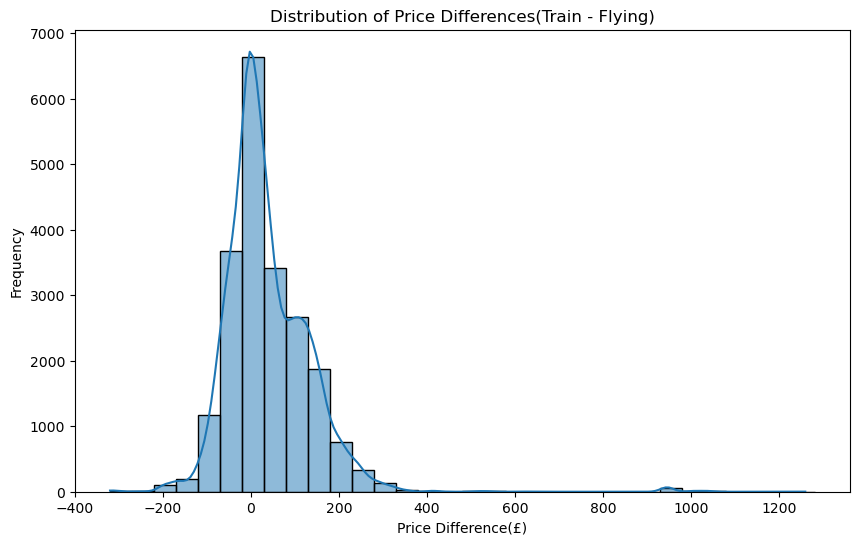

In [259]:
# Plot the distribution of price differences
plt.figure(figsize=(10, 6))
sns.histplot(df5['price_difference'].dropna(), kde=True, binwidth=50)
plt.title('Distribution of Price Differences(Train - Flying)')
plt.xlabel('Price Difference(£)')
plt.ylabel('Frequency')
plt.show()

#### 4.3 Lastly, we try to make clear the probability of traveling by train and plane with both price and time advantages.

In [248]:
cheaper_train = df5[df5['price_difference'] < 0]
time_comparison = cheaper_train[['cheapest_train_opt_time', 'cheapest_flying_opt_time']]
train_time_less = time_comparison[time_comparison['cheapest_train_opt_time'] < time_comparison['cheapest_flying_opt_time']]

cheaper_flying = df5[df5['price_difference'] > 0]
time_comparison_1 = cheaper_flying[['cheapest_train_opt_time', 'cheapest_flying_opt_time']]
flying_time_less = time_comparison_1[time_comparison_1['cheapest_train_opt_time'] > time_comparison_1['cheapest_flying_opt_time']]


percentage_train_time_price_less = (len(train_time_less) / len(df5['price_difference'].dropna())) * 100
percentage_flying_time_price_less = (len(flying_time_less) / len(df5['price_difference'].dropna())) * 100

print("Percentage of train win in both time and price is:", f"{percentage_train_time_price_less:.2f}%")
print("Percentage of plane win in both time and price is:", f"{percentage_flying_time_price_less:.2f}%")

Percentage of train win in both time and price is: 6.20%
Percentage of plane win in both time and price is: 58.07%


**In addition to this, when a scholar has a choice between train and plane, the train has both a time and price advantage in only 6.20% of the cases, while the fast and cheap plane appears in a high of 58.07 % of the cases. This shows that aeroplanes are in most cases not only advantageous in terms of cost but also more time efficient.**</p>**Therefore, for academics attending international conferences that require flying, if time efficiency is the primary consideration (and probability is that it is the dominant factor), choosing an airplane will usually be the better decision, especially if the airplane is cheaper.**</p>**These data emphasize, on the one hand, the need to improve the time efficiency of railways, especially on routes where train prices are already dominant, and where improving the speed and convenience of train services may improve their position in the competition. On the other hand, it may be possible to try to find effective price regulation to guide academics to travel green to reduce the number of flights and reduce the carbon emissions of academic conferences.**

In [251]:
# emission

emission_data1 = {
    'fly': 4.167,
    'fly_combined': 4.167 * 0.95,
    'train': 0.018,
    'train_combined': 0.018 * 0.95
}

def calculate_emissions(time_min, transport):
    if pd.isna(time_min) or pd.isna(transport):
        return None
    
    transport = transport.lower().strip('[]').replace("'", "").split(',')
    transport = [t.strip() for t in transport]

    if len(transport) == 1:
        transport_type = transport[0]
        return time_min * emission_data1.get(transport_type, 0)
    elif 'fly' in transport and 'train' not in transport:
        return time_min * emission_data1['fly_combined']
    elif 'train' in transport and 'fly' not in transport:
        return time_min * emission_data1['train_combined']
    elif 'fly' in transport and 'train' in transport:
        return time_min * max(emission_data1['fly_combined'], emission_data1['train_combined'])
    elif 'train' in transport:
        return time_min * emission_data1['train_combined']
    else:
        return time_min * max(emission_data1.get(t, 0) for t in transport)


df5['cheapest_train_opt_emission'] = df5.apply(lambda row: calculate_emissions(row['cheapest_train_opt_time'], row['cheapest_train_opt_transport']), axis=1)
df5['cheapest_flying_opt_emission'] = df5.apply(lambda row: calculate_emissions(row['cheapest_flying_opt_time'], row['cheapest_flying_opt_transport']), axis=1)


df5['cheapest_train_opt_emission'] = df5['cheapest_train_opt_emission'] / 1000
df5['cheapest_flying_opt_emission'] = df5['cheapest_flying_opt_emission'] / 1000

print(df5[['cheapest_train_opt_emission', 'cheapest_flying_opt_emission']].head(20))

    cheapest_train_opt_emission  cheapest_flying_opt_emission
0                           NaN                      3.962817
1                           NaN                      7.802499
2                           NaN                      4.136789
3                           NaN                      9.009887
4                           NaN                      7.538103
5                           NaN                      5.716291
6                      0.036320                      1.931821
7                           NaN                      1.492411
8                           NaN                      3.912813
9                           NaN                      1.425114
10                          NaN                      4.132831
11                          NaN                      4.462857
12                          NaN                      1.600128
13                          NaN                      4.132831
14                     0.022999                      1.037166
15      

In [258]:
valid_count = df5['cheapest_train_opt_emission'].notna() & df5['cheapest_flying_opt_emission'].notna()

valid_count_sum = valid_count.sum()

print(f"Number of rows where both 'cheapest_train_opt_emission' and 'cheapest_flying_opt_emission' are not NaN: {valid_count_sum}")

Number of rows where both 'cheapest_train_opt_emission' and 'cheapest_flying_opt_emission' are not NaN: 21083


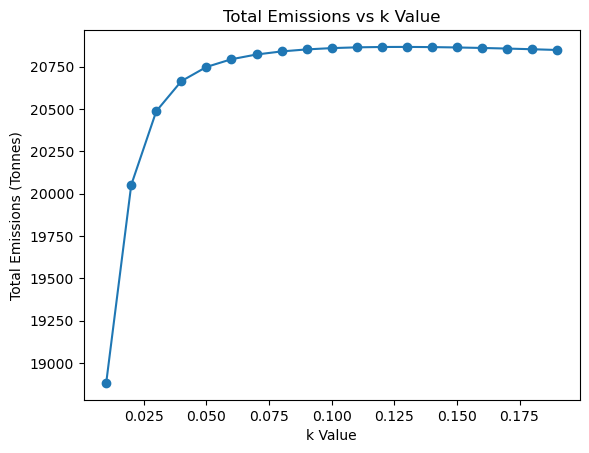

The optimal k value is: 0.01


In [261]:

def calculate_choice_probability(df5, k, mode='price'):
    if mode == 'price':
        df5['train_probability'] = 1 / (1 + np.exp(k * (df5['cheapest_train_opt_price'] - df5['cheapest_flying_opt_price'])))
    elif mode == 'time':
        df5['train_probability'] = 1 / (1 + np.exp(k * (df5['cheapest_train_opt_time'] - df5['cheapest_flying_opt_time'])))
    return df5

def calculate_total_emissions(df5):
    df5['weighted_emissions'] = df5['train_probability'] * df5['cheapest_train_opt_emission'] + (1 - df5['train_probability']) * df5['cheapest_flying_opt_emission']
    total_emissions = df5['weighted_emissions'].sum()
    return total_emissions

# Select range k values and simulate
k_values = np.arange(0.01, 0.2, 0.01)
emission_results = []

for k in k_values:
    df5 = calculate_choice_probability(df5, k, mode='price')  # Assuming we base our calculations on prices
    total_emissions = calculate_total_emissions(df5)
    emission_results.append(total_emissions)


plt.plot(k_values, emission_results, marker='o')
plt.xlabel('k Value')
plt.ylabel('Total Emissions (Tonnes)')
plt.title('Total Emissions vs k Value')
plt.show()


optimal_k = k_values[np.argmin(emission_results)]
print(f'The optimal k value is: {optimal_k}')


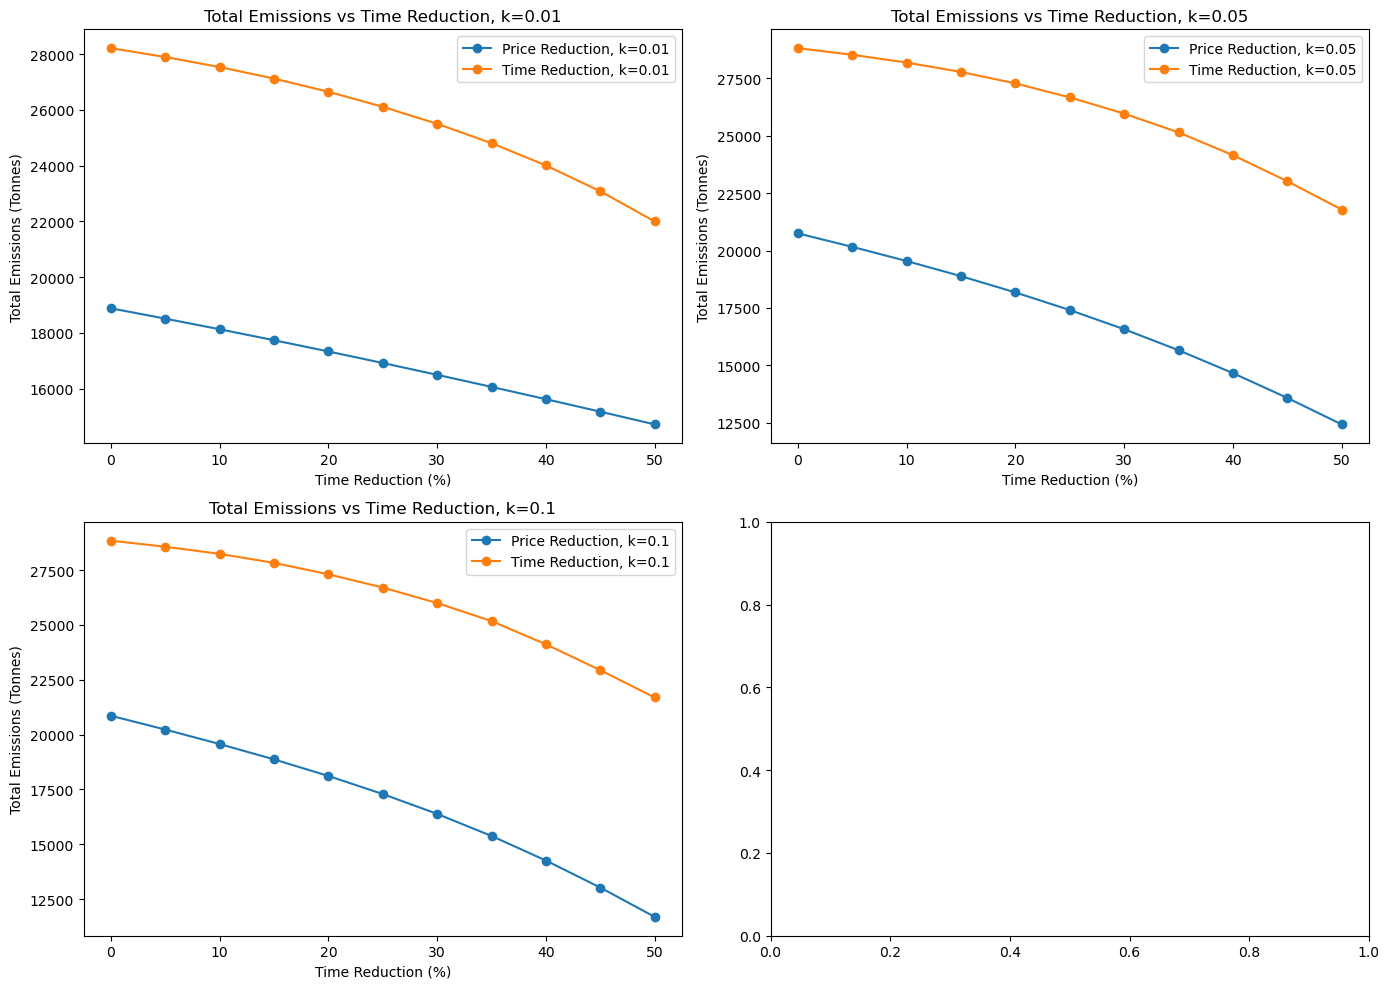

In [266]:
# find optimal k value

def calculate_choice_probability(df5, k, mode='price'):
    if mode == 'price':
        df5['train_probability'] = 1 / (1 + np.exp(k * (df5['adjusted_train_price'] - df5['cheapest_flying_opt_price'])))
    elif mode == 'time':
        df5['train_probability'] = 1 / (1 + np.exp(k * (df5['adjusted_train_time'] - df5['cheapest_flying_opt_time'])))
    return df5


def calculate_total_emissions(df5):
    df5['weighted_emissions'] = df5['train_probability'] * df5['cheapest_train_opt_emission'] + (1 - df5['train_probability']) * df5['cheapest_flying_opt_emission']
    total_emissions = df5['weighted_emissions'].sum()
    return total_emissions


def analyze_price_reduction(df5, k, reduction_percentages):
    results = []
    for reduction in reduction_percentages:
        df5['adjusted_train_price'] = df5['cheapest_train_opt_price'] * (1 - reduction)
        df5 = calculate_choice_probability(df5, k, mode='price')
        total_emissions = calculate_total_emissions(df5)
        results.append((reduction * 100, total_emissions))
    return results


def analyze_time_reduction(df5, k, reduction_percentages):
    results = []
    for reduction in reduction_percentages:
        df5['adjusted_train_time'] = df5['cheapest_train_opt_time'] * (1 - reduction)
        df5 = calculate_choice_probability(df5, k, mode='time')
        total_emissions = calculate_total_emissions(df5)
        results.append((reduction * 100, total_emissions))
    return results


k_values = [0.01, 0.05, 0.1]


fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, k in enumerate(k_values):
    price_reduction_percentages = np.arange(0, 0.51, 0.05)  
    time_reduction_percentages = np.arange(0, 0.51, 0.05)  
    
    price_reduction_results = analyze_price_reduction(df5.copy(), k, price_reduction_percentages)
    time_reduction_results = analyze_time_reduction(df5.copy(), k, time_reduction_percentages)
    
 
    price_reduction_df = pd.DataFrame(price_reduction_results, columns=['Price Reduction (%)', 'Total Emissions (Tonnes)'])
    time_reduction_df = pd.DataFrame(time_reduction_results, columns=['Time Reduction (%)', 'Total Emissions (Tonnes)'])
    

    axes[idx].plot(price_reduction_df['Price Reduction (%)'], price_reduction_df['Total Emissions (Tonnes)'], marker='o', label=f'Price Reduction, k={k}')
    axes[idx].set_title(f'Total Emissions vs Price Reduction, k={k}')
    axes[idx].set_xlabel('Price Reduction (%)')
    axes[idx].set_ylabel('Total Emissions (Tonnes)')
    axes[idx].legend()


for idx, k in enumerate(k_values):
    time_reduction_percentages = np.arange(0, 0.51, 0.05)  
    
    time_reduction_results = analyze_time_reduction(df5.copy(), k, time_reduction_percentages)
    
    time_reduction_df = pd.DataFrame(time_reduction_results, columns=['Time Reduction (%)', 'Total Emissions (Tonnes)'])
    
    axes[idx + 3 - len(k_values)].plot(time_reduction_df['Time Reduction (%)'], time_reduction_df['Total Emissions (Tonnes)'], marker='o', label=f'Time Reduction, k={k}')
    axes[idx + 3 - len(k_values)].set_title(f'Total Emissions vs Time Reduction, k={k}')
    axes[idx + 3 - len(k_values)].set_xlabel('Time Reduction (%)')
    axes[idx + 3 - len(k_values)].set_ylabel('Total Emissions (Tonnes)')
    axes[idx + 3 - len(k_values)].legend()

plt.tight_layout()
plt.show()


In [270]:

optimal_k = 0.1

# define train probability
def calculate_choice_probability(df5, k, mode='price'):
    if mode == 'price':
        df5['train_probability'] = 1 / (1 + np.exp(k * (df5['adjusted_train_price'] - df5['cheapest_flying_opt_price'])))
    elif mode == 'time':
        df5['train_probability'] = 1 / (1 + np.exp(k * (df5['adjusted_train_time'] - df5['cheapest_flying_opt_time'])))
    return df5

# define weighted_emission
def calculate_total_emissions(df5):
    df5['weighted_emissions'] = df5['train_probability'] * df5['cheapest_train_opt_emission'] + (1 - df5['train_probability']) * df5['cheapest_flying_opt_emission']
    total_emissions = df5['weighted_emissions'].sum()
    return total_emissions

#  Assumption1: reduce ticket price
def analyze_price_reduction(df5, k, reduction_percentages):
    results = []
    for reduction in reduction_percentages:
        df5['adjusted_train_price'] = df5['cheapest_train_opt_price'] * (1 - reduction)
        df5 = calculate_choice_probability(df5, k, mode='price')
        total_emissions = calculate_total_emissions(df5)
        results.append((reduction * 100, total_emissions))
    return results

# Assumption2: reduce time cost
def analyze_time_reduction(df5, k, reduction_percentages):
    results = []
    for reduction in reduction_percentages:
        df5['adjusted_train_time'] = df5['cheapest_train_opt_time'] * (1 - reduction)
        df5 = calculate_choice_probability(df5, k, mode='time')
        total_emissions = calculate_total_emissions(df5)
        results.append((reduction * 100, total_emissions))
    return results


price_reduction_percentages = np.arange(0, 0.51, 0.05)  
time_reduction_percentages = np.arange(0, 0.51, 0.05)  

price_reduction_results = analyze_price_reduction(df5.copy(), optimal_k, price_reduction_percentages)
time_reduction_results = analyze_time_reduction(df5.copy(), optimal_k, time_reduction_percentages)


price_reduction_df = pd.DataFrame(price_reduction_results, columns=['Price Reduction (%)', 'Total Emissions (Tonnes)'])
time_reduction_df = pd.DataFrame(time_reduction_results, columns=['Time Reduction (%)', 'Total Emissions (Tonnes)'])


initial_price_emissions = price_reduction_df['Total Emissions (Tonnes)'].iloc[0]
price_reduction_df['Emissions Reduction (%)'] = 100 * (initial_price_emissions - price_reduction_df['Total Emissions (Tonnes)']) / initial_price_emissions

initial_time_emissions = time_reduction_df['Total Emissions (Tonnes)'].iloc[0]
time_reduction_df['Emissions Reduction (%)'] = 100 * (initial_time_emissions - time_reduction_df['Total Emissions (Tonnes)']) / initial_time_emissions

price_reduction_df = price_reduction_df.round({'Total Emissions (Tonnes)': 2, 'Emissions Reduction (%)': 2})
time_reduction_df = time_reduction_df.round({'Total Emissions (Tonnes)': 2, 'Emissions Reduction (%)': 2})


print("Price Reduction Analysis:")
print(price_reduction_df)
print("\nTime Reduction Analysis:")
print(time_reduction_df)

Price Reduction Analysis:
    Price Reduction (%)  Total Emissions (Tonnes)  Emissions Reduction (%)
0                   0.0                  20859.22                     0.00
1                   5.0                  20228.74                     3.02
2                  10.0                  19568.64                     6.19
3                  15.0                  18868.51                     9.54
4                  20.0                  18112.70                    13.17
5                  25.0                  17288.46                    17.12
6                  30.0                  16383.55                    21.46
7                  35.0                  15376.68                    26.28
8                  40.0                  14256.63                    31.65
9                  45.0                  13022.61                    37.57
10                 50.0                  11687.53                    43.97

Time Reduction Analysis:
    Time Reduction (%)  Total Emissions (Tonnes)

In [61]:
import pycountry_convert as pc

def iso3_to_continent(iso3):
    try:
        iso2 = pc.country_alpha3_to_country_alpha2(iso3)
        continent_code = pc.country_alpha2_to_continent_code(iso2)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except:
        return "Unknown"

df1['continent_origin'] = df1['iso3_origin'].apply(iso3_to_continent)
df1['continent_dest'] = df1['iso3_dest'].apply(iso3_to_continent)

continent_to_region = {
    'Asia': 'Asia',
    'Europe': 'Europe',  
    'Africa': 'Africa',
    'North America': 'Northern America',  
    'South America': 'Latin America and the Caribbean',  
    'Central America': 'Latin America and the Caribbean',  
    'Caribbean': 'Latin America and the Caribbean',  
    'Australia': 'Oceania', 
    'Oceania': 'Oceania',  
    'Antarctica': 'Others',
    'Unknown': 'Others'
}


def country_to_subregion(iso3):
    try:
        iso2 = pc.country_alpha3_to_country_alpha2(iso3)
        subregion = pc.country_alpha2_to_subregion(iso2)
        return subregion
    except:
        return "Unknown"

df1['subregion_origin'] = df1['iso3_origin'].apply(country_to_subregion)
df1['subregion_dest'] = df1['iso3_dest'].apply(country_to_subregion)


df1['region_origin'] = df1['continent_origin'].apply(lambda x: continent_to_region[x] if x in continent_to_region else continent_to_region[country_to_subregion(x)])
df1['region_dest'] = df1['continent_dest'].apply(lambda x: continent_to_region[x] if x in continent_to_region else continent_to_region[country_to_subregion(x)])

df1['region_origin'].info()
df1['region_dest'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 70432 entries, 0 to 70431
Series name: region_origin
Non-Null Count  Dtype 
--------------  ----- 
70432 non-null  object
dtypes: object(1)
memory usage: 550.4+ KB
<class 'pandas.core.series.Series'>
RangeIndex: 70432 entries, 0 to 70431
Series name: region_dest
Non-Null Count  Dtype 
--------------  ----- 
70432 non-null  object
dtypes: object(1)
memory usage: 550.4+ KB


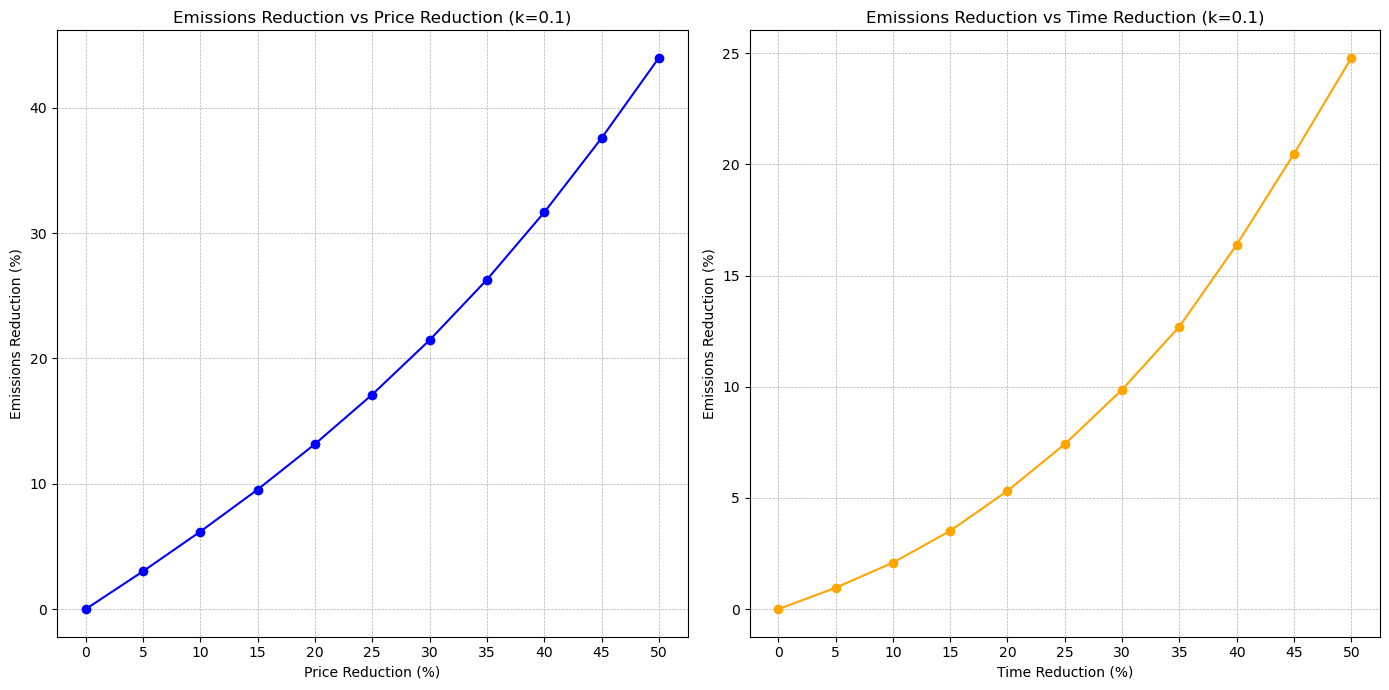

In [271]:
plt.figure(figsize=(14, 7))

# Plot for Price Reduction vs Emissions Reduction
plt.subplot(1, 2, 1)
plt.plot(price_reduction_df['Price Reduction (%)'], price_reduction_df['Emissions Reduction (%)'], marker='o', color='blue')
plt.title('Emissions Reduction vs Price Reduction (k=0.1)')
plt.xlabel('Price Reduction (%)')
plt.ylabel('Emissions Reduction (%)')

# Adding grid lines and dotted lines to the plot
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(price_reduction_df['Price Reduction (%)'])  # Ensure all x-ticks are shown
plt.yticks()  # Ensure all y-ticks are shown

# Plot for Time Reduction vs Emissions Reduction
plt.subplot(1, 2, 2)
plt.plot(time_reduction_df['Time Reduction (%)'], time_reduction_df['Emissions Reduction (%)'], marker='o', color='orange')
plt.title('Emissions Reduction vs Time Reduction (k=0.1)')
plt.xlabel('Time Reduction (%)')
plt.ylabel('Emissions Reduction (%)')

# Adding grid lines and dotted lines to the plot
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(time_reduction_df['Time Reduction (%)'])  # Ensure all x-ticks are shown
plt.yticks()  # Ensure all y-ticks are shown

plt.tight_layout()
plt.show()


### 5. What can be done when transport modes other than airplanes are not available?

In [272]:
df6 = pd.read_csv('base_final_v2.csv')

In [273]:
df6. info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89123 entries, 0 to 89122
Data columns (total 62 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   name                           89123 non-null  object 
 1   citations                      74477 non-null  float64
 2   first_publication_year         74831 non-null  float64
 3   is_presenter                   89123 non-null  int64  
 4   year                           89123 non-null  int64  
 5   link                           89123 non-null  object 
 6   conf_name                      89123 non-null  object 
 7   conf_name_alt                  89123 non-null  object 
 8   country_origin                 83360 non-null  object 
 9   iso3_origin                    84738 non-null  object 
 10  latitude_origin                83360 non-null  float64
 11  longitude_origin               83360 non-null  float64
 12  country_dest                   86911 non-null 

In [275]:
valid_entries = df6.dropna(subset=['cheapest_train_opt_price', 'cheapest_flying_opt_price', 
                                   'cheapest_train_opt_time', 'cheapest_flying_opt_time',
                                   'cheapest_train_opt_transport', 'cheapest_flying_opt_transport'
                                  ])

valid_count = len(valid_entries)

print(f"Number of sample choosing between plana and train: {valid_count}")


Number of sample choosing between plana and train: 27622


In [276]:
df6['cheapest_train_opt_time'] = df6['cheapest_train_opt_time'].apply(time_to_minutes)
df6['cheapest_flying_opt_time'] = df6['cheapest_flying_opt_time'].apply(time_to_minutes)

In [278]:
df6['cheapest_train_opt_price'] = df6['cheapest_train_opt_price'].apply(convert_price)
df6['cheapest_flying_opt_price'] = df6['cheapest_flying_opt_price'].apply(convert_price)

In [280]:
df6['cheapest_train_opt_emission'] = df6.apply(lambda row: calculate_emissions(row['cheapest_train_opt_time'], row['cheapest_train_opt_transport']), axis=1)
df6['cheapest_flying_opt_emission'] = df6.apply(lambda row: calculate_emissions(row['cheapest_flying_opt_time'], row['cheapest_flying_opt_transport']), axis=1)


df6['cheapest_train_opt_emission'] = df6['cheapest_train_opt_emission'] / 1000
df6['cheapest_flying_opt_emission'] = df6['cheapest_flying_opt_emission'] / 1000

print(df6[['cheapest_train_opt_emission', 'cheapest_flying_opt_emission']].head(20))

    cheapest_train_opt_emission  cheapest_flying_opt_emission
0                           NaN                      5.517108
1                           NaN                           NaN
2                      0.045828                      1.559708
3                      0.045828                      1.559708
4                           NaN                      6.438015
5                           NaN                           NaN
6                      0.048510                      1.383444
7                           NaN                      2.529369
8                           NaN                           NaN
9                      0.013122                      0.981745
10                          NaN                      8.721531
11                     0.012636                      0.910489
12                     0.013122                      0.981745
13                     0.013122                      0.981745
14                          NaN                      5.333760
15      

In [357]:
def iso3_to_continent(iso3):
    try:
        iso2 = pc.country_alpha3_to_country_alpha2(iso3)
        continent_code = pc.country_alpha2_to_continent_code(iso2)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except:
        return "Unknown"

df6['continent_origin'] = df6['iso3_origin'].apply(iso3_to_continent)
df6['continent_dest'] = df6['iso3_dest'].apply(iso3_to_continent)

continent_to_region = {
    'Asia': 'Asia',
    'Europe': 'Europe',  
    'Africa': 'Africa',
    'North America': 'Northern America',  
    'South America': 'Latin America and the Caribbean',  
    'Central America': 'Latin America and the Caribbean',  
    'Caribbean': 'Latin America and the Caribbean',  
    'Australia': 'Oceania', 
    'Oceania': 'Oceania',  
    'Antarctica': 'Others',
    'Unknown': 'Others'
}


def country_to_subregion(iso3):
    try:
        iso2 = pc.country_alpha3_to_country_alpha2(iso3)
        subregion = pc.country_alpha2_to_subregion(iso2)
        return subregion
    except:
        return "Unknown"

df6['subregion_origin'] = df6['iso3_origin'].apply(country_to_subregion)
df6['subregion_dest'] = df6['iso3_dest'].apply(country_to_subregion)

df6['region_origin'] = df6['continent_origin'].apply(lambda x: continent_to_region[x] if x in continent_to_region else continent_to_region[country_to_subregion(x)])
df6['region_dest'] = df6['continent_dest'].apply(lambda x: continent_to_region[x] if x in continent_to_region else continent_to_region[country_to_subregion(x)])

df6['region_origin'].info()
df6['region_dest'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 89123 entries, 0 to 89122
Series name: region_origin
Non-Null Count  Dtype 
--------------  ----- 
89123 non-null  object
dtypes: object(1)
memory usage: 696.4+ KB
<class 'pandas.core.series.Series'>
RangeIndex: 89123 entries, 0 to 89122
Series name: region_dest
Non-Null Count  Dtype 
--------------  ----- 
89123 non-null  object
dtypes: object(1)
memory usage: 696.4+ KB


In [397]:

df_filtered = df6[(df6['cheapest_flying_opt_time'].notnull()) & (df6['cheapest_train_opt_time'].isnull())]


df_filtered = df_filtered.dropna(subset=['latitude_origin', 'longitude_origin', 'latitude_dest', 'longitude_dest'])


def calculate_distance(row):
    coords_origin = (row['latitude_origin'], row['longitude_origin'])
    coords_dest = (row['latitude_dest'], row['longitude_dest'])
    return geopy.distance.geodesic(coords_origin, coords_dest).km

df_filtered['estimated_distance_km'] = df_filtered.apply(calculate_distance, axis=1)


df_filtered['same_region'] = df_filtered['region_origin'] == df_filtered['region_dest']
df_filtered['same_country'] = df_filtered['country_eng_origin'] == df_filtered['country_eng_dest']


def analyze_sample(row):
    if row['same_region']:
        if row['same_country']:
            return "Within the same country"
        else:
            return "Within the same region, different countries"
    else:
        return "Different regions"

df_filtered['analysis_result'] = df_filtered.apply(analyze_sample, axis=1)


def classify_distance(distance):
    if distance > 800:  
        return "Long-distance"
    else:
        return "Short-distance"

df_filtered['distance_classification'] = df_filtered['estimated_distance_km'].apply(classify_distance)


summary = df_filtered.groupby(['analysis_result', 'distance_classification']).agg({
    'cheapest_flying_opt_emission': ['sum', 'mean'],
    'estimated_distance_km': ['count', 'mean']
}).reset_index()


print(f"Total emissions from flights: {total_emissions_fly:.2f} tonnes")


print("\nSummary of Emissions by Region and Distance Classification:")
print(summary)

Total emissions from flights: 172254.17 tonnes

Summary of Emissions by Region and Distance Classification:
                               analysis_result distance_classification  \
                                                                         
0                            Different regions           Long-distance   
1                            Different regions          Short-distance   
2                      Within the same country           Long-distance   
3                      Within the same country          Short-distance   
4  Within the same region, different countries           Long-distance   
5  Within the same region, different countries          Short-distance   

  cheapest_flying_opt_emission           estimated_distance_km               
                           sum      mean                 count         mean  
0                131850.726381  4.549872                 28979  8503.385498  
1                   313.307979  1.712065                   183   

/tmp/ipykernel_14663/4029886541.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(analysis_results + ' (' + distance_classifications + ')', fontweight='bold')


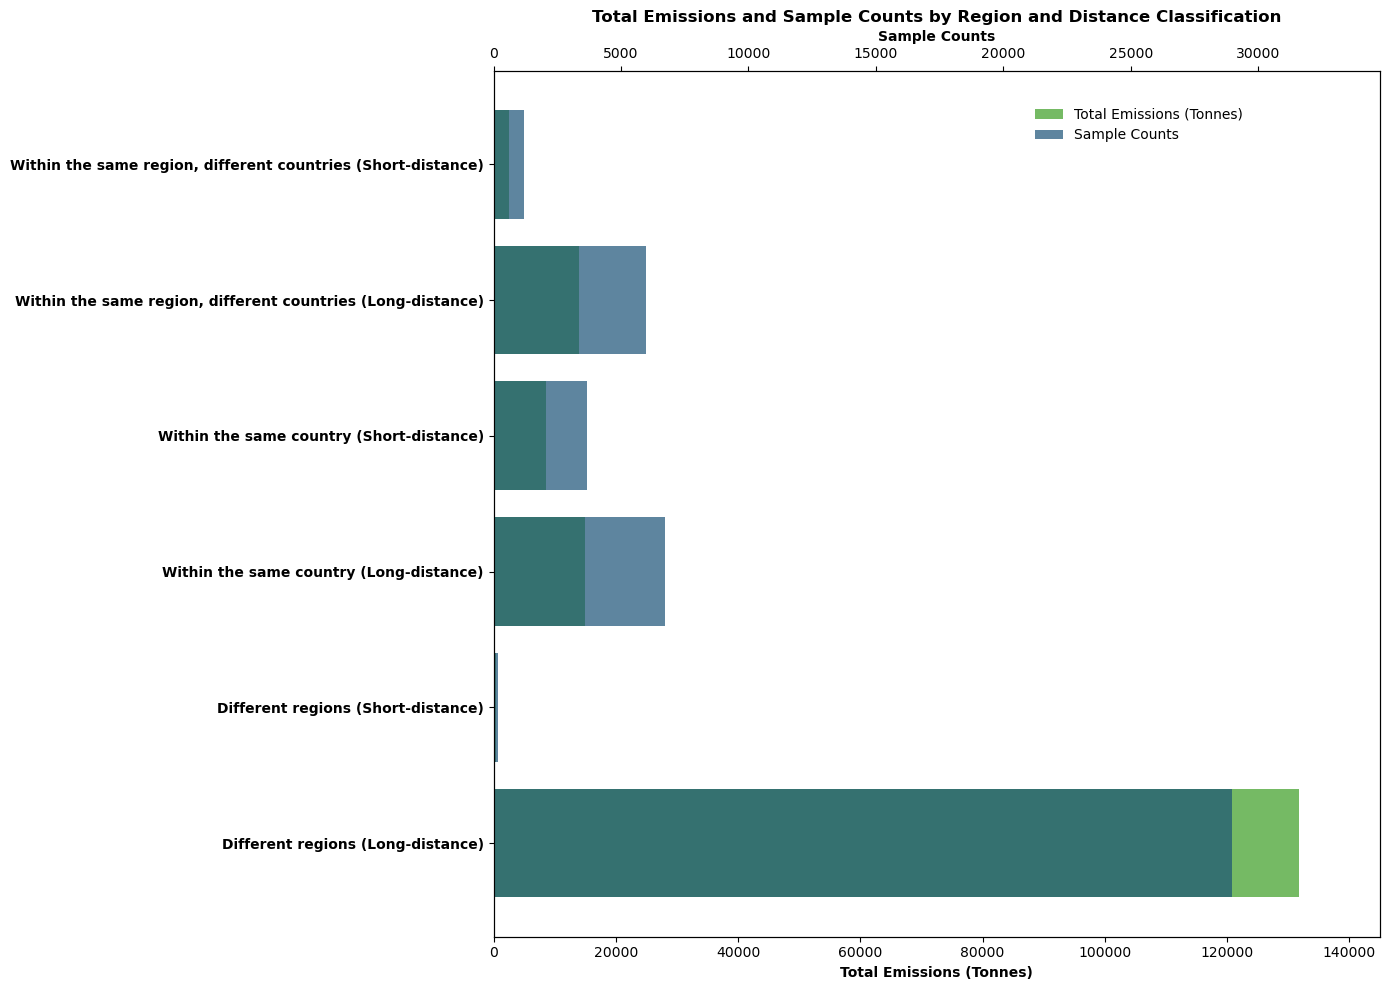

In [396]:

analysis_results = summary['analysis_result']
distance_classifications = summary['distance_classification']
total_emissions = summary[('cheapest_flying_opt_emission', 'sum')]
sample_counts = summary[('estimated_distance_km', 'count')]


color_emissions = '#3A9D23'  
color_sample_counts = '#1A5276'


fig, ax1 = plt.subplots(figsize=(14, 10))


ax1.barh(analysis_results + ' (' + distance_classifications + ')', total_emissions, color=color_emissions, alpha=0.7, label='Total Emissions (Tonnes)')
ax1.set_xlabel('Total Emissions (Tonnes)', fontweight='bold')


ax1.set_xlim(0, max(total_emissions) * 1.1)


ax2 = ax1.twiny()
ax2.barh(analysis_results + ' (' + distance_classifications + ')', sample_counts, color=color_sample_counts, alpha=0.7, label='Sample Counts')
ax2.set_xlabel('Sample Counts', fontweight='bold')

ax2.set_xlim(0, max(sample_counts) * 1.2)

ax1.set_ylabel('')

ax1.set_yticklabels(analysis_results + ' (' + distance_classifications + ')', fontweight='bold')

fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9), frameon=False)

plt.title('Total Emissions and Sample Counts by Region and Distance Classification', fontweight='bold')

plt.tight_layout()

plt.show()